# Lista 07 - Classificação Multiclasse

> Yanna Torres Gonçalves
> 
> Matrícula: 587299
> 
> strado em Ciências da Computação

In [ ]:
!pip install faiss-gpu-cu12
!pip install scikit-learn fuzzywuzzy python-Levenshtein spacy nltk sentence_transformers emoji unidecode
!pip install imblearn

In [ ]:
!python -m spacy download pt_core_news_sm

In [2]:
import pandas as pd
import numpy as np
import re

import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from fuzzywuzzy import fuzz
import spacy
from tqdm import tqdm
tqdm.pandas()

nltk.download('punkt')
nltk.download('stopwords')

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## Parte 01: limpeza e pré-processamento dos dados

### a) Ler o dataset fakeTelegram.BR_2022.csv

In [ ]:
data_url = "https://media.githubusercontent.com/media/yanna-torres/CKP9011-ciencia-de-dados/refs/heads/lista-01/data/fakeTelegram.BR_2022.csv"

df = pd.read_csv(data_url)

In [ ]:
df.describe()

### b) Remova os trava-zaps, as linhas repetidas e textos com menos de 5 palavras

#### Removando trava-zaps

In [ ]:
def has_trava_zap(message):
    if not isinstance(message, str):
        return False  # Garante que só analisa strings

    # Regra 1: muito longo
    if len(message) > 10000:
        return True

    # Regra 2: caracteres invisíveis
    invisible = ''.join(chr(c) for c in range(0x200B, 0x200F + 1)) + '\uFEFF'
    if sum(message.count(c) for c in invisible) > 100:
        return True

    # Regra 3: emojis repetidos
    emoji_pattern = re.compile("[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF"
                              "\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+", flags=re.UNICODE)
    emojis = emoji_pattern.findall(message)
    if any(len(e) > 20 for e in emojis):
        return True

    # Regra 4: baixa diversidade
    unique = set(message)
    if len(unique) < 10 and len(message) > 500:
        return True

    return False

In [ ]:
df['trava_zap'] = df['text_content_anonymous'].apply(has_trava_zap)
df_clean = df[df['trava_zap'] == False]
df_clean.drop(columns=['trava_zap'], inplace=True)

#### Removendo as linhas repetidas


In [ ]:
df_clean = df_clean.drop_duplicates()

#### Removendo textos com menos de 5 palavras

In [ ]:
df_clean = df_clean[df_clean['text_content_anonymous'].str.split().str.len() >= 5]

### c) Agrupe as linhas com postagens iguais ou semelhantes

In [ ]:
df_clean.columns

In [ ]:
import emoji
import unidecode

def normalize_text(text):
    text = str(text).lower()
    text = re.sub(r"https?://\S+|www\.\S+", " ", text)
    text = emoji.replace_emoji(text, " ")
    text = re.sub(r"[^\w\sÀ-ÿ]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [ ]:
df_clean['text_normalized'] = df_clean['text_content_anonymous'].progress_apply(normalize_text)

In [ ]:
df_clean = df_clean[df_clean['text_normalized'].notnull()]
df_clean = df_clean[df_clean['text_normalized'] != ""]
df_clean = df_clean[df_clean['text_normalized'].str.split().str.len() >= 5]

In [ ]:
print("Data length:")
print(len(df_clean))

In [ ]:
# Remove exact duplicates and count occurrences as "shares"
df_grouped = (
    df_clean.groupby('text_normalized', as_index=False)
      .agg({
            'date_message': 'min',
            'id_member_anonymous': 'first',
            **{col: 'first' for col in df_clean.columns if col != 'text_normalized' and col != 'date_message'}
      })
)

In [ ]:
share_counts = df_clean['text_content_anonymous'].value_counts().to_dict()
df_grouped['shares'] = df_grouped['text_content_anonymous'].map(share_counts)

In [ ]:
print("New Data length:")
print(len(df_grouped))

In [ ]:
df_grouped.head(5)

In [ ]:
from sentence_transformers import SentenceTransformer
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2', device=device)

In [ ]:
# Get embeddings (batch-processed on GPU)
texts = df_grouped['text_normalized'].tolist()
print("Encoding texts into embeddings...")
embeddings = model.encode(texts, batch_size=64, show_progress_bar=True, device=device)
df_grouped['embedding'] = embeddings.tolist()

In [ ]:
df_grouped = df_grouped.reset_index(drop=True)
embeddings_array = np.array(df_grouped['embedding'].tolist())

In [ ]:
import faiss

faiss.normalize_L2(embeddings)
dimension = embeddings.shape[1]
index = faiss.IndexFlatIP(dimension)
index.add(embeddings)

In [ ]:
from collections import defaultdict

similarity_threshold = 0.9
k = 1000

clusters = defaultdict(list)
removed_indices = set()

for i in tqdm(range(len(df_grouped))):
    if i in removed_indices:
        continue
    vec = embeddings[i].reshape(1, -1)
    D, I = index.search(vec, k)
    for sim, j in zip(D[0][1:], I[0][1:]):
        if j == -1 or j == i or j in removed_indices:
            continue
        if sim >= similarity_threshold:
            clusters[i].append(j)
            removed_indices.add(j)

In [ ]:
results = []
used = set()

for base_idx, sim_indices in tqdm(clusters.items()):
    if base_idx in used:
        continue
    total_count = df_grouped.iloc[base_idx]['shares']
    used.add(base_idx)
    for sim_idx in sim_indices:
        total_count += df_grouped.iloc[sim_idx]['shares']
        used.add(sim_idx)
    row = df_grouped.iloc[base_idx].copy()
    row['shares'] = total_count
    results.append(row)

# Add remaining unmatched
remaining = df_grouped.loc[~df_grouped.index.isin(used)].copy()
final_df = pd.concat([pd.DataFrame(results), remaining], ignore_index=True)

In [ ]:
final_df.drop(columns=['embedding']).to_csv("grouped_by_similarity.csv")

In [ ]:
len(final_df)

### d) Colunas Auxiliares

Para facilitar a recuperação de dados em alguns casos, vamos criar colunas auxiliares.

In [ ]:
import regex

def is_latin_only(text):
    # This keeps only rows that are entirely Latin script (with punctuation, digits, spaces)
    return bool(regex.fullmatch(r'[\p{Latin}\d\s\p{P}\p{S}]+', str(text)))

cleaned_df = final_df[final_df['text_normalized'].apply(is_latin_only)]

In [ ]:
stop_words = set(stopwords.words('portuguese', 'english'))

def clean_text(text):
    if not isinstance(text, str):
        return ''
    text_no_punct = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text_no_punct)
    filtered = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered)

cleaned_df['text_no_stopwords'] = cleaned_df['text_normalized'].progress_apply(clean_text)

In [ ]:
cleaned_df['word_count'] = cleaned_df['text_normalized'].progress_apply(lambda x: len(x.split()) if pd.notnull(x) else 0)
cleaned_df['character_count'] = cleaned_df['text_normalized'].progress_apply(lambda x: len(x) if pd.notnull(x) else 0)

In [ ]:
def classify_misinformation(score):
    if score >= 0.66:
        return 'Misinformation'
    elif score >= 0.33:
        return 'Neutral'
    else:
        return 'Non-misinformation'

cleaned_df['misinformation_category'] = cleaned_df['score_misinformation'].progress_apply(classify_misinformation)

In [ ]:
cleaned_df['sentiment_category'] = cleaned_df['score_sentiment'].progress_apply(lambda x: "Positive" if x >= 0.05 else ("Negative" if x <= -0.05 else "Neutral"))

In [ ]:
cleaned_df.drop(columns=['embedding']).to_csv("grouped_cleaned.csv")

In [3]:
cleaned_df = pd.read_csv("../grouped_cleaned.csv")

#### Gerar os diferentes embeddings

##### TF-IDF

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=300)
X_tfidf = tfidf.fit_transform(cleaned_df['text_normalized']).toarray()

cleaned_df['tfidf_embedding'] = list(X_tfidf)

##### BoW

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer(max_features=300)
X_bow = bow.fit_transform(cleaned_df['text_normalized']).toarray()

cleaned_df['bow_embedding'] = list(X_bow)

##### Word2Vec

In [6]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

tokenized_texts = cleaned_df['text_normalized'].progress_apply(word_tokenize)
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

100%|██████████| 177088/177088 [00:20<00:00, 8605.63it/s] 


In [7]:
import numpy as np

def get_avg_word2vec(tokens, model, vector_size):
    valid_tokens = [token for token in tokens if token in model.wv]
    if valid_tokens:
        return np.mean(model.wv[valid_tokens], axis=0)
    else:
        return np.zeros(vector_size)

cleaned_df['word2vec_embedding'] = tokenized_texts.progress_apply(lambda tokens: get_avg_word2vec(tokens, w2v_model, 100))

100%|██████████| 177088/177088 [00:12<00:00, 14260.60it/s]


## Parte 02: Modelo Preditivo (Classificador Multiclasse)

Utilizando os dados referente a postagens no Telegram, crie um modelo preditivo (classificador multiclasse) para classificar uma mensagem em níveis de viralidade.

Escolha uma estratégia para definir o número de níveis de viralidade (classes).

Por exemplo, você definir quatro níveis de viralidade a partir dos quartis da quantidade de compartilhamentos.

In [8]:
cleaned_df[["shares", "text_content_anonymous"]].sort_values(by='shares', ascending=False).head(50)

shares                             text_content_anonymous
5063     17423  Grupo a diretoria bloqueado:\n\nEstá comunidad...
2617      1607  Comentarios de Anderson Martinho de 29 años. B...
46        1425  1, pressione o botão abaixo dentro de 3 Minuto...
9249      1282  Welcome, 00\n\n🔸 [USER] — professional tool fo...
7052      1256  Olá 1...2...3...5...8...13...21...34...55...89...
7122      1090  🚨Olá SEJA bem vindo(a) 1- ao grupo Especulando...
7055       724  Olá 182 (-) \n\nSeja bem vindo(a) ao grupo DIR...
4551       698  Feedback de Afonso Rico 27 ​​anos.  Brasil, Li...
9274       627  Welcome, A MARCOLINO Maranata\n\n🔸 [USER] — pr...
2152       534  Bom ter você por aqui, 1. 🇧🇷\n\nConsulte as me...
9256       527  Welcome, 27061 Alicia\n\n🔸 [USER] — profession...
4548       517  Feedback de Adriana fenado 38 anos. Brazil, SO...
2628       485  Comentários de Danail Fábio, 56 anos. Brasil, ...
7054       448  Olá 18132 (-) \n\nSeja bem vindo(a) ao grupo D...
1814       364  ⚠️ BEM-VINDO! ⚠️\n\nEste Grupo é Para Juntar e...
31152      358  Bem vindo(a) ao grupo Ipirá Notícias. \n\nComp...
9266       339  Welcome, 81235 Ana Silva\n\n🔸 [USER] — profess...
9255       332  Welcome, 20372 Florencio Barros\n\n🔸 [USER] — ...
8220       330             Screenshot (1 de nov de 2022 01:53:14)
70         323  12899, pressione o botão abaixo dentro de 5 Mi...
8305       320  Seja bem vindo ao grupo 10krnzin 📚 Este grupo ...
181        319  48733, pressione o botão abaixo dentro de 2 Mi...
333        295  *A ESQUERDA ESTA AGINDO NOS GRUPOS DE WHATSAPP...
9279       285  Welcome, Aakanksha Gupta\n\n🔸 [USER] — profess...
9280       279  Welcome, Aaldea BertoMeu\n\n🔸 [USER] — profess...
9267       249  Welcome, 97039 Paulo Moreira\n\n🔸 [USER] — pro...
8075       208  Regras do Grupo \n\n1° Regra do grupo é respei...
9313       207  Welcome, Adilio Santos\n\n🔸 [USER] — professio...
6096       204  Meu povo, ânimo! A vida segue!\n\n\n\nPara que...
4309       201  Eu disse Há infiltrados AQUI e é VERDADE     ....
7299       200  #panorama [USER]\n\n▪️ 01/11/2022 - 00:00 \nEs...
171506     195                     Vídeo de AVANY FERREIRA MULLER
9270       191  Welcome, A Costa\n\n🔸 [USER] — professional to...
171630     189                   Vídeo de Maria Teresa D  Valente
7300       185  #panorama [USER] \n #commodities \n▪️ 01/11/20...
74508      184                    Foto de Maria Teresa D  Valente
954        183  *AMANHÃ DIA TODO\n02/11/2022\n\nVAMOS LEVANTAR...
2632       178  Comentários de Maria \n35 anos. Brasil, Rio Gr...
9360       174  Welcome, Alejandra Vasquez\n\n🔸 [USER] — profe...
9253       174  Welcome, 18 Luis\n\n🔸 [USER] — professional to...
171667     171                           Vídeo de R A S G A N D O
19         163  [1/11 10:00] 🌻🌻🌻: Bom dia!! Sou advogada e vou...
9252       158  Welcome, 152 Carlos Augusto Kohl\n\n🔸 [USER] —...
102        151  [19/10 15:45] Frank: Já que lula colocou um mi...
681        149  Adilson Joao, pressione o botão abaixo dentro ...
109        147  [2/11 08:46] Madson Psi: *VAMOS SEGUIR O INSTA...
2647       146  COMIGO COMIGO RECEBEM MAIS TARDE✅, SEU LUCRO E...
2620       145  Comentarios de Paulo Barroso 30 años. Brasil, ...
9277       144  Welcome, AA%#es\n\n🔸 [USER] — professional too...
7301       144  #panorama [USER] \n #criptomoedas \n▪️ 01/11/2...

In [9]:
cleaned_df[["shares", "text_content_anonymous"]][cleaned_df['shares'] <= 100].sort_values(by='shares', ascending=False).head(50)

shares                             text_content_anonymous
4196       100  Estou muito feliz com esta plataforma Fiz um i...
148         99  🇧🇷 2º Turno - Compartilhe 🇧🇷\n\nLista atualiza...
2659        97  .COMO COMEÇAR\n\n  1. Prepare seus fundos.\n\n...
8306        97  Seja bem vindo ao grupo 3rr0 📚 Este grupo é li...
2465        96  *CDBr INFORMA:*\n\n*VAMOS MOSTRAR AOS PETRALHA...
6177        95  🌒 MODO NOTURNO INICIADO\n\n❌ A partir deste mo...
9322        94  Welcome, Adriana Martins\n\n🔸 [USER] — profess...
7034        93  Ola! Tudo bem? A nossa enquete eleitoral esta ...
437         91  https://youtu.be/u-ZGL90PfeIJUNTE-SE A NÓS TAM...
9343        91  Welcome, Ajay Kumar\n\n🔸 [USER] — professional...
9292        91  Welcome, Abedalrhman Sarsour\n\n🔸 [USER] — pro...
9363        91  Welcome, Alex lefevre\n\n🔸 [USER] — profession...
18195       90  ⚡️🇧🇷 Actus Liberandi - Ordem De Cristo 🇧🇷\n\n✨...
5456        90  INVISTA CONOSCO E RECEBA✅\n   A SEU LUCRO ESTÁ...
3175        89  Cuidado pessoal tão postando em todos os grupo...
2012        84  Bolsonaro está perto de fazer 3 milhões e meio...
8           83                                           [04/1...
387         83  A hora é agora .. Nas ruas e Já mandei por e-m...
3808        83  ENTRA EM MIM\n\n   OLÁ\n\n   OLÁ\n\n   Com lic...
9273        82  Welcome, A. J.\n\n🔸 [USER] — professional tool...
2713        81  🇧🇷🔆🇧🇷🔆🇧🇷🔆🇧🇷🔆 🇧🇷💥🇧🇷💥🇧🇷💥🇧🇷 COMPARTILHE.............
5078        80  grupo [USER] venha edificar sua fé para se tor...
2626        80  Comentários de Antônio Luiz \n41 anos. Brasil,...
9346        76  Welcome, ALAIDES GIMENES\n\n🔸 [USER] — profess...
84527       76  Irmãos de DIREITA, COMPARTILHEM o MÁXIMO, VAMO...
654         76  Acompanhando  a matemática q percebo agora. An...
1596        76  Atenção Pessoal orientação do nosso amigo da P...
2785        75  Congrats & Thank you very much for your wonder...
9198        75                        Vídeo de Ana Mello Vianna 💞
4033        74  ESTA FALTANDO BRASILEIROS QUE VOTOU NO BOLSONA...
3845        74  ENVIE O SEU PEDIDO AGORA, ESTAMOS ABERTOS\n\nc...
249         74  _Só repassando _\nATENÇÃO🇧🇷\n\nUm jornalista d...
171518      73                     Vídeo de Cecília Lima De Moura
9014        73  [USER] [1001117563] está floodando. \nAção: Ad...
9332        73  Welcome, Afonso Pereira\n\n🔸 [USER] — professi...
6093        72  meu grande investidor está testemunhando como ...
4607        72  Feedback de Marcos  23 anos. Brasil, Diadema.\...
20          72  [1/11 13:37] +55 [PHONE]: Oficiais do exército...
7073        71  Olá Alexandra (-) \n\nSeja bem vindo(a) ao gru...
4574        71  Feedback de David Henriques 27 anos. Brazil, F...
531         70  A suspeita é que nas vésperas, uns 2 dias ante...
9193        69                                   Vídeo de A Í D A
96          69  16200 [656109889] está floodando. \nAção: Adve...
9342        68  Welcome, Airon Oliveiraa\n\n🔸 [USER] — profess...
4570        68  Feedback de Cleiton \n41 anos. Brasil, Alagoas...
7057        68  Olá a todos, Acabei de receber o pagamento e e...
4933        68  Gente precisam entender isso PATRIOTA LEIAM O ...
9271        67  Welcome, A.D.C\n\n🔸 [USER] — professional tool...
6248        67  Muitas vidas se transformaram aqui, muitas vid...
194         66  🥀 [5334705226] para participar neste grupo, po...

In [10]:
training_final_df = cleaned_df[cleaned_df['shares'] <= 100]

In [11]:
len(training_final_df)

177012

### Features

In [15]:
mean = training_final_df["shares"].mean()
std = training_final_df["shares"].std()

def classify_multiclass(shares):
    if shares < mean - std:
        return 0  # muito pouco compartilhado
    elif shares < mean:
        return 1  # pouco
    elif shares < mean + std:
        return 2  # bastante
    else:
        return 3  # muito viral

training_final_df["viral_level"] = training_final_df["shares"].apply(classify_multiclass)

/tmp/ipykernel_16234/4092017900.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_final_df["viral_level"] = training_final_df["shares"].apply(classify_multiclass)


In [18]:
training_final_df[["shares", "text_content_anonymous", "viral_level"]].head(10)

shares                             text_content_anonymous  viral_level
0        2                      🗳📃 — 0,31% dos votos contados            2
2       12       *02.10.2022 TSE - Governo-SP às 18h 59m 00s*            3
3       15       02.10.2022 TSE - Presidente - às 18h 55m 31s            3
4        2            02.10.2022 TSE - Prévia das 17h 44m 10s            2
5        9          02.10.2022 TSE - Senado-SP às 19h 20m 53s            3
6       26  *02/11 AS 09:00*\n\n\nPRA RUA!!!!🇧🇷🇧🇷🇧🇷🇧🇷🇧🇷🇧🇷🇧...            3
7        8  03.10.22 - Attention: Fraud verified in Brazil...            3
8       83                                           [04/1...            3
9        2  *05/11/2011 - Dr Marcelo Frazão foi BANIDO/CEN...            2
11       2  06/11/2022 - Rio de Janeiro -  Comando Militar...            2

In [19]:
training_final_df["date_message"] = pd.to_datetime(training_final_df["date_message"])
training_final_df["hour"] = training_final_df["date_message"].dt.hour
training_final_df["day_of_week"] = training_final_df["date_message"].dt.dayofweek

/tmp/ipykernel_16234/4185041234.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_final_df["date_message"] = pd.to_datetime(training_final_df["date_message"])
/tmp/ipykernel_16234/4185041234.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_final_df["hour"] = training_final_df["date_message"].dt.hour
/tmp/ipykernel_16234/4185041234.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [20]:
from sklearn.preprocessing import LabelEncoder

for col in ["media_type", "sentiment_category", "misinformation_category"]:
    training_final_df[col] = training_final_df[col].fillna("unknown")
    training_final_df[col] = LabelEncoder().fit_transform(training_final_df[col])

/tmp/ipykernel_16234/1949680538.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_final_df[col] = training_final_df[col].fillna("unknown")
/tmp/ipykernel_16234/1949680538.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_final_df[col] = LabelEncoder().fit_transform(training_final_df[col])
/tmp/ipykernel_16234/1949680538.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [21]:
feature_cols = [
    "word_count", "character_count", "score_sentiment", "score_misinformation",
    "has_media", "sentiment_category", "misinformation_category",
    "hour", "day_of_week"
]

In [22]:
training_final_null_df = training_final_df.dropna(subset=feature_cols)

In [23]:
training_final_null_df.isnull().sum()

Unnamed: 0                     0
text_normalized                0
date_message                   0
id_member_anonymous        47645
id_group_anonymous             0
media                      62237
media_type                     0
media_url                  66633
has_media                      0
has_media_url                  0
text_content_anonymous         0
dataset_info_id                0
date_system                    0
score_sentiment                0
score_misinformation           0
id_message                     0
message_type                   0
messenger                      0
media_name                 82135
media_md5                  62237
shares                         0
text_no_stopwords              0
word_count                     0
character_count                0
misinformation_category        0
sentiment_category             0
tfidf_embedding                0
bow_embedding                  0
word2vec_embedding             0
is_viral                       0
viral_leve

In [24]:
embedding_matrix_tfidf = np.vstack(training_final_null_df["tfidf_embedding"])
embedding_matrix_bow = np.vstack(training_final_null_df["bow_embedding"])
embedding_matrix_word2vec = np.vstack(training_final_null_df["word2vec_embedding"])

In [25]:
X_base = training_final_null_df[feature_cols].values
X_tfidf = np.hstack([X_base, embedding_matrix_tfidf])
X_bow = np.hstack([X_base, embedding_matrix_bow])
X_word2vec = np.hstack([X_base, embedding_matrix_word2vec])
y = training_final_null_df["viral_level"]

#### Visualizações

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

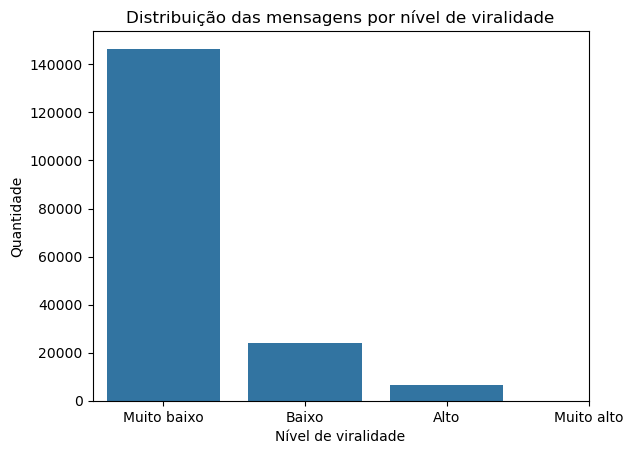

In [28]:
sns.countplot(x="viral_level", data=training_final_df)
plt.title("Distribuição das mensagens por nível de viralidade")
plt.xlabel("Nível de viralidade")
plt.ylabel("Quantidade")
plt.xticks([0, 1, 2, 3], ["Muito baixo", "Baixo", "Alto", "Muito alto"])
plt.show()

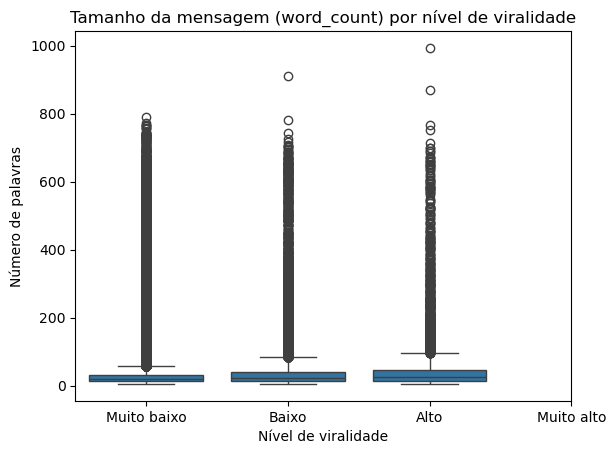

In [30]:
sns.boxplot(x="viral_level", y="word_count", data=training_final_df)
plt.title("Tamanho da mensagem (word_count) por nível de viralidade")
plt.xlabel("Nível de viralidade")
plt.ylabel("Número de palavras")
plt.xticks([0, 1, 2, 3], ["Muito baixo", "Baixo", "Alto", "Muito alto"])
plt.show()

### Treinamento

In [34]:
from sklearn.model_selection import train_test_split

X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(
    X_tfidf, y, stratify=y, test_size=0.2, random_state=42
)

X_bow_train, X_bow_test, y_bow_train, y_bow_test = train_test_split(
    X_bow, y, stratify=y, test_size=0.2, random_state=42
)

X_word2vec_train, X_word2vec_test, y_word2vec_train, y_word2vec_test = train_test_split(
    X_word2vec, y, stratify=y, test_size=0.2, random_state=42
)

#### Regressão Logística

In [ ]:
!pip install imblearn

In [35]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    classification_report, roc_curve, auc, confusion_matrix
)
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
def run_logistic_experiment(
    X_train, X_test, y_train, y_test,
    balance_strategy=None,
    normalize=None,
    penalty="l2",
    solver="liblinear",
    class_weight=None,
    max_iter=1000,
    l1_ratio=None,
    verbose=True
):
    print(f"\n🔧 Config: balance={balance_strategy}, normalize={normalize}, penalty={penalty}, weight={class_weight}")

    # Normalize
    if normalize == "zscore":
        scaler = StandardScaler()
    elif normalize == "minmax":
        scaler = MinMaxScaler()
    else:
        scaler = None

    if scaler:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # Balance
    if balance_strategy == "smote":
        sampler = SMOTE(random_state=42)
    elif balance_strategy == "ros":
        sampler = RandomOverSampler(random_state=42)
    elif balance_strategy == "rus":
        sampler = RandomUnderSampler(random_state=42)
    else:
        sampler = None

    if sampler:
        X_train, y_train = sampler.fit_resample(X_train, y_train)

    # Train model
    model = LogisticRegression(
        solver=solver,
        penalty=penalty,
        class_weight=class_weight,
        max_iter=max_iter,
        l1_ratio=l1_ratio,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    class_labels = sorted(np.unique(y_test))
    target_names = [str(label) for label in class_labels]

    print("\n📊 Classification Report")
    report_dict = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    print(classification_report(y_test, y_pred, target_names=target_names))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=class_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=target_names, yticklabels=target_names)
    plt.title("Matriz de Confusão")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

    # ROC Curve (apenas se for binária)
    if len(class_labels) == 2:
        y_scores = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (área = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel("Falso Positivo (FPR)")
        plt.ylabel("Verdadeiro Positivo (TPR)")
        plt.title("Curva ROC")
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()

    # Plot métricas por classe
    df_plot = pd.DataFrame(report_dict).transpose().loc[target_names, ["precision", "recall", "f1-score"]]
    sns.heatmap(df_plot, annot=True, fmt=".2f", cmap="Greens")
    plt.title("Desempenho por Classe")
    plt.ylabel("Classe")
    plt.show()

    return report_dict

In [37]:
experiment_configs = [
    # Baseline
    {"normalize": None, "balance_strategy": None, "penalty": "l1", "class_weight": None},

    # Regularization
    {"normalize": "zscore", "balance_strategy": None, "penalty": "l1", "class_weight": None},
    {"normalize": "zscore", "balance_strategy": None, "penalty": "l2", "class_weight": None},
    {"normalize": "zscore", "balance_strategy": None, "penalty": "elasticnet", "class_weight": None},

    # Normalization variants
    {"normalize": "minmax", "balance_strategy": None, "penalty": "l2", "class_weight": None},

    # Class weighting
    {"normalize": "zscore", "balance_strategy": None, "penalty": "l2", "class_weight": "balanced"},

    # With balancing
    {"normalize": "zscore", "balance_strategy": "smote", "penalty": "l2", "class_weight": None},
    {"normalize": "zscore", "balance_strategy": "ros", "penalty": "l2", "class_weight": None},
    {"normalize": "zscore", "balance_strategy": "rus", "penalty": "l2", "class_weight": None},
]

##### TF-IDF


📌 Running Experiment 1/9
{'normalize': None, 'balance_strategy': None, 'penalty': 'l1', 'class_weight': None}

🔧 Config: balance=None, normalize=None, penalty=l1, weight=None

📊 Classification Report
              precision    recall  f1-score   support

           1       0.82      0.98      0.89     13267
           2       0.44      0.11      0.18      2498
           3       0.55      0.02      0.04       768

    accuracy                           0.81     16533
   macro avg       0.60      0.37      0.37     16533
weighted avg       0.75      0.81      0.75     16533



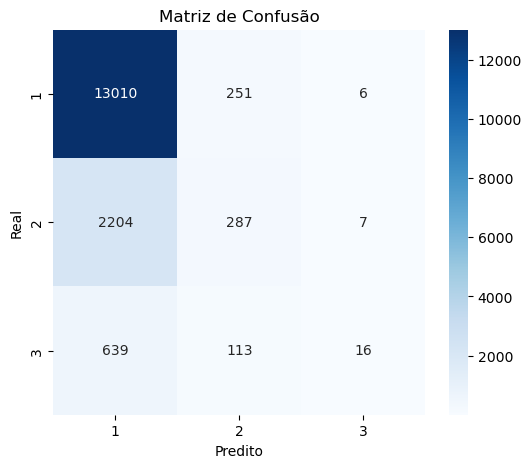

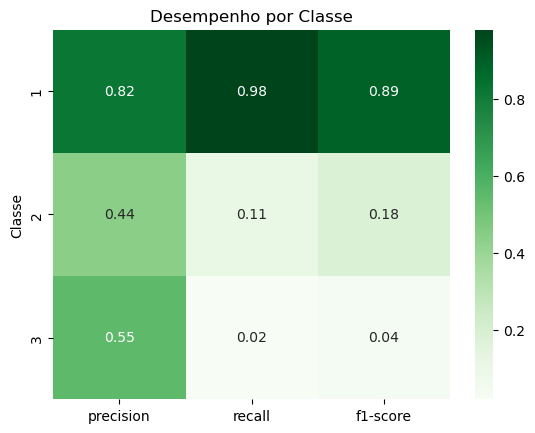


📌 Running Experiment 2/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'l1', 'class_weight': None}

🔧 Config: balance=None, normalize=zscore, penalty=l1, weight=None

📊 Classification Report
              precision    recall  f1-score   support

           1       0.82      0.98      0.89     13267
           2       0.44      0.12      0.18      2498
           3       0.53      0.02      0.04       768

    accuracy                           0.80     16533
   macro avg       0.60      0.37      0.37     16533
weighted avg       0.75      0.80      0.75     16533



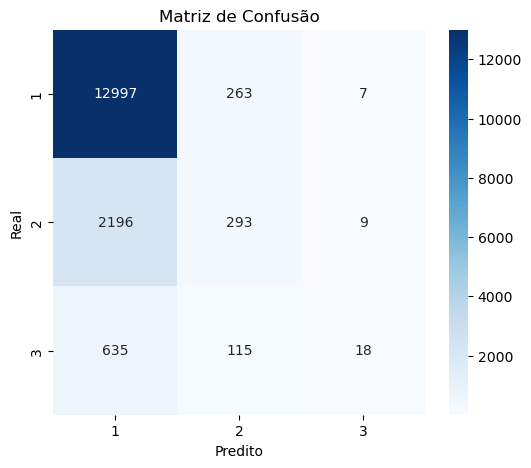

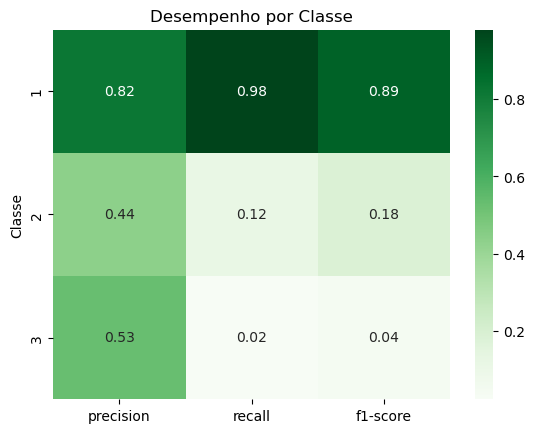


📌 Running Experiment 3/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=None, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

           1       0.82      0.98      0.89     13267
           2       0.43      0.12      0.18      2498
           3       0.50      0.02      0.04       768

    accuracy                           0.80     16533
   macro avg       0.59      0.37      0.37     16533
weighted avg       0.75      0.80      0.75     16533



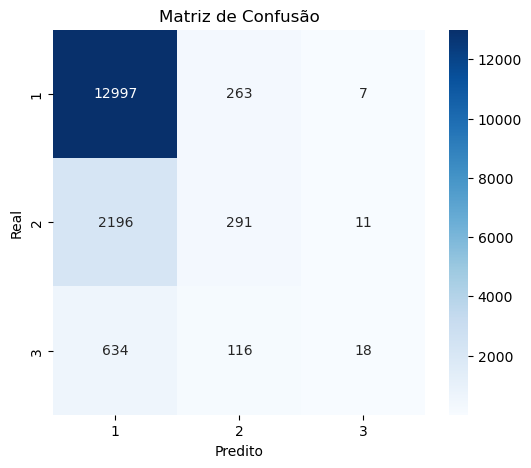

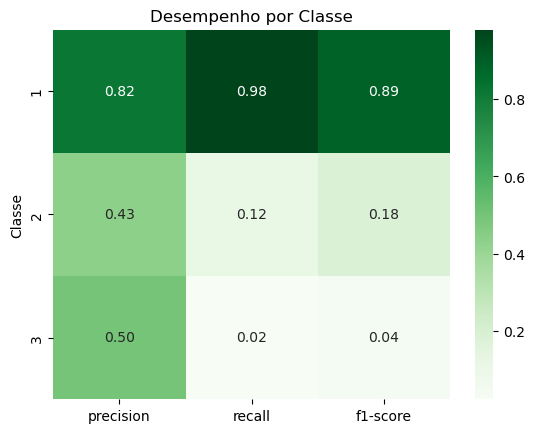


📌 Running Experiment 4/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'elasticnet', 'class_weight': None}

🔧 Config: balance=None, normalize=zscore, penalty=elasticnet, weight=None

📊 Classification Report
              precision    recall  f1-score   support

           1       0.82      0.98      0.89     13267
           2       0.44      0.12      0.18      2498
           3       0.41      0.03      0.06       768

    accuracy                           0.80     16533
   macro avg       0.56      0.38      0.38     16533
weighted avg       0.75      0.80      0.75     16533



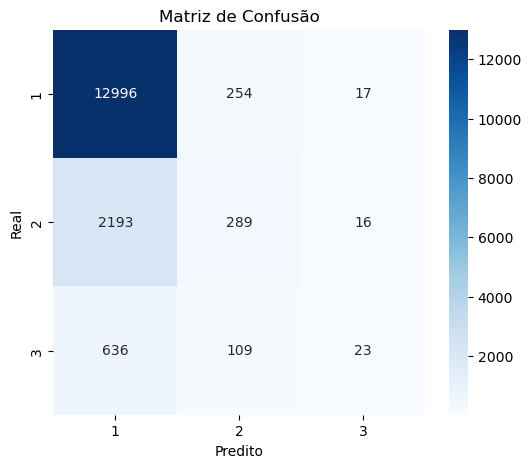

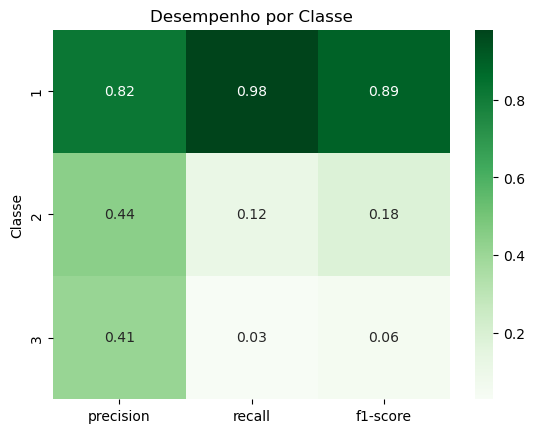


📌 Running Experiment 5/9
{'normalize': 'minmax', 'balance_strategy': None, 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=None, normalize=minmax, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

           1       0.82      0.98      0.89     13267
           2       0.44      0.12      0.18      2498
           3       0.54      0.02      0.04       768

    accuracy                           0.81     16533
   macro avg       0.60      0.37      0.37     16533
weighted avg       0.75      0.81      0.75     16533



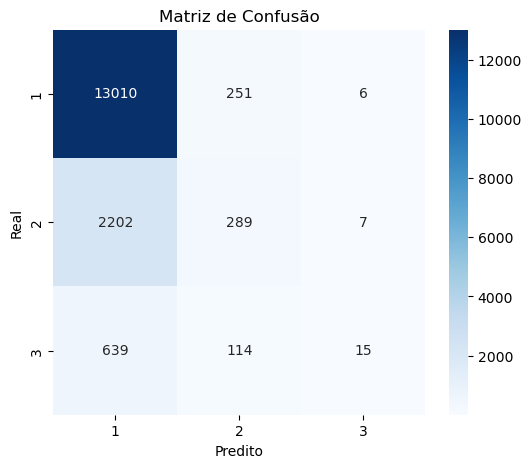

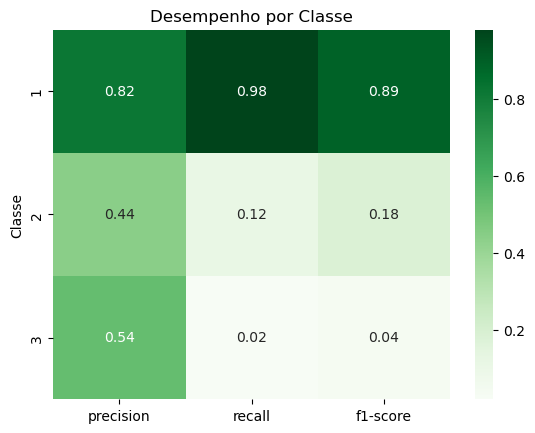


📌 Running Experiment 6/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'l2', 'class_weight': 'balanced'}

🔧 Config: balance=None, normalize=zscore, penalty=l2, weight=balanced

📊 Classification Report
              precision    recall  f1-score   support

           1       0.87      0.87      0.87     13267
           2       0.35      0.26      0.30      2498
           3       0.17      0.29      0.22       768

    accuracy                           0.75     16533
   macro avg       0.46      0.47      0.46     16533
weighted avg       0.76      0.75      0.75     16533



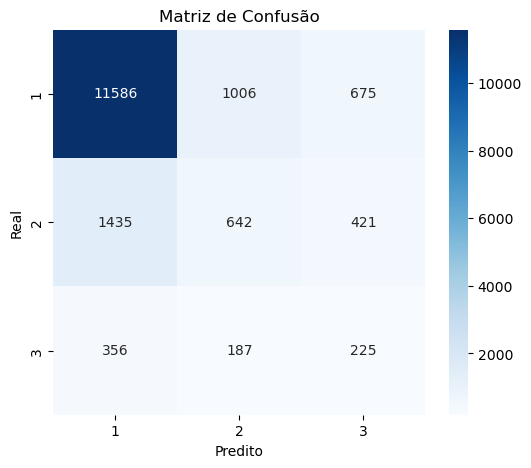

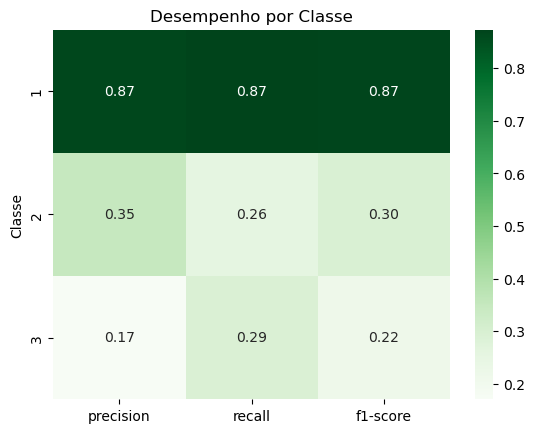


📌 Running Experiment 7/9
{'normalize': 'zscore', 'balance_strategy': 'smote', 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=smote, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

           1       0.89      0.74      0.81     13267
           2       0.27      0.33      0.30      2498
           3       0.13      0.40      0.19       768

    accuracy                           0.66     16533
   macro avg       0.43      0.49      0.43     16533
weighted avg       0.76      0.66      0.70     16533



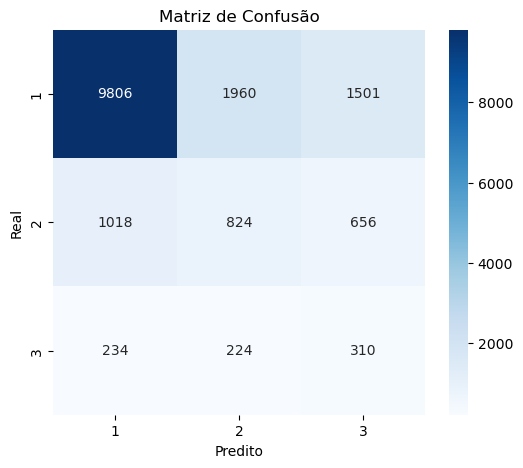

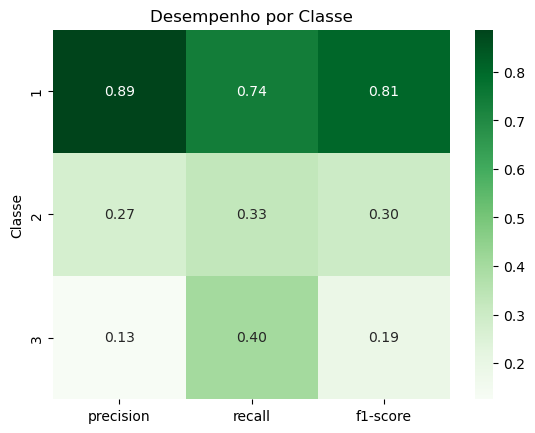


📌 Running Experiment 8/9
{'normalize': 'zscore', 'balance_strategy': 'ros', 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=ros, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

           1       0.91      0.70      0.79     13267
           2       0.27      0.34      0.30      2498
           3       0.13      0.53      0.20       768

    accuracy                           0.63     16533
   macro avg       0.43      0.52      0.43     16533
weighted avg       0.78      0.63      0.69     16533



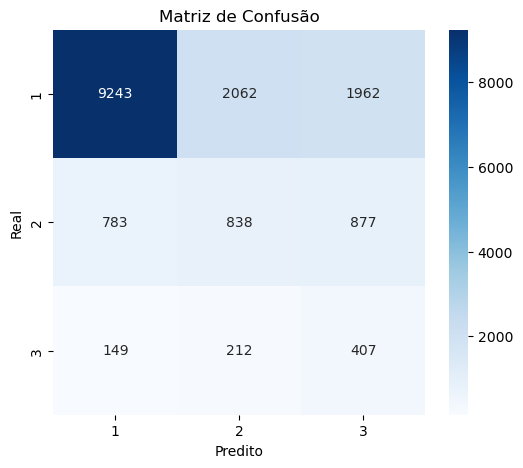

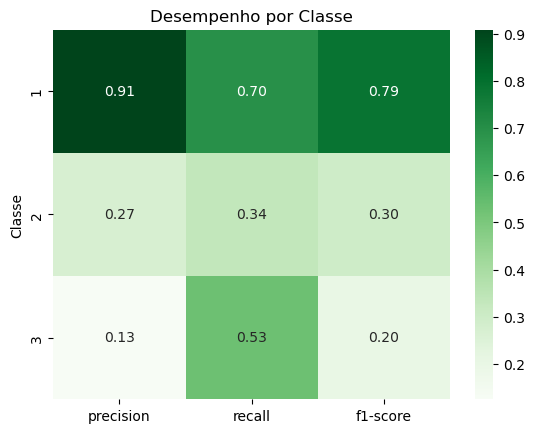


📌 Running Experiment 9/9
{'normalize': 'zscore', 'balance_strategy': 'rus', 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=rus, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

           1       0.91      0.66      0.77     13267
           2       0.24      0.33      0.28      2498
           3       0.12      0.52      0.20       768

    accuracy                           0.61     16533
   macro avg       0.42      0.51      0.41     16533
weighted avg       0.77      0.61      0.67     16533



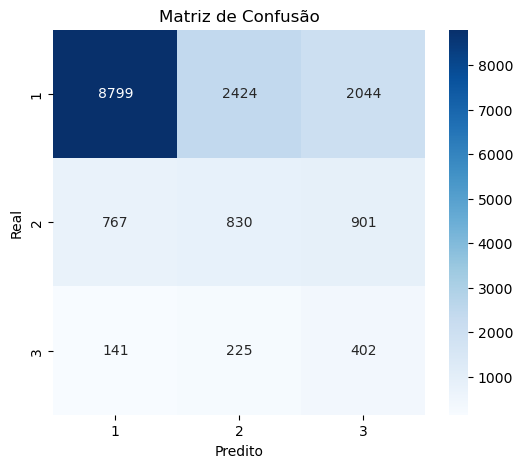

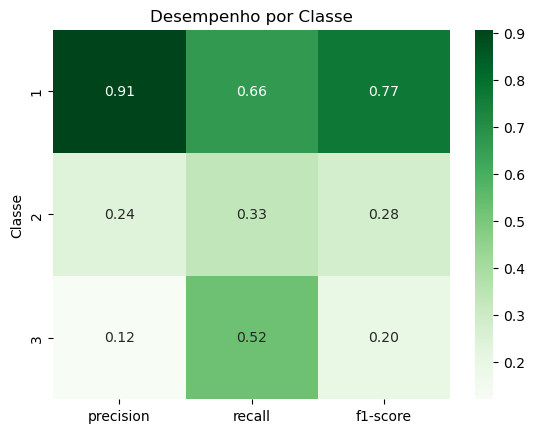

In [39]:
results_regression_tfidf = []

solver_for_penalty = {
    "l1": "liblinear",
    "l2": "liblinear",
    "elasticnet": "saga"
}

for i, config in enumerate(experiment_configs):
    print(f"\n📌 Running Experiment {i+1}/{len(experiment_configs)}")
    print(config)

    # Dynamically assign solver and l1_ratio
    penalty = config["penalty"]
    solver = solver_for_penalty[penalty]
    l1_ratio = 0.5 if penalty == "elasticnet" else None

    report_dict = run_logistic_experiment(
        X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test,
        normalize=config["normalize"],
        balance_strategy=config["balance_strategy"],
        penalty=penalty,
        solver=solver,
        class_weight=config["class_weight"],
        l1_ratio=l1_ratio,
        verbose=False
    )

    macro_f1 = report_dict["macro avg"]["f1-score"]

    most_viral_class = str(max(np.unique(y_tfidf_test)))
    viral_f1 = report_dict.get(most_viral_class, {}).get("f1-score", 0.0)

    results_regression_tfidf.append({
        **config,
        "solver": solver,
        "l1_ratio": l1_ratio,
        "macro_f1": macro_f1,
        "viral_f1": viral_f1
    })


##### BOW


📌 Running Experiment 1/9
{'normalize': None, 'balance_strategy': None, 'penalty': 'l1', 'class_weight': None}

🔧 Config: balance=None, normalize=None, penalty=l1, weight=None

📊 Classification Report
              precision    recall  f1-score   support

           1       0.82      0.98      0.89     13267
           2       0.44      0.11      0.18      2498
           3       0.55      0.02      0.04       768

    accuracy                           0.81     16533
   macro avg       0.60      0.37      0.37     16533
weighted avg       0.75      0.81      0.75     16533



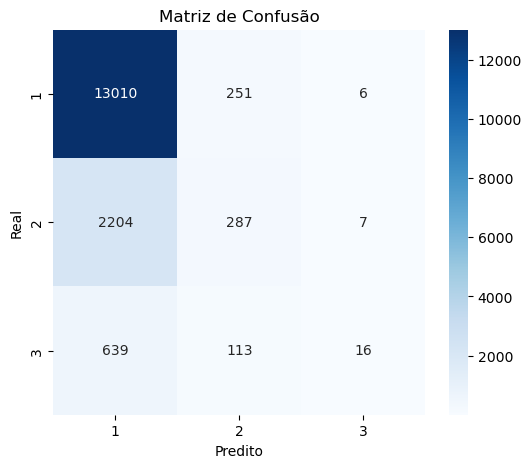

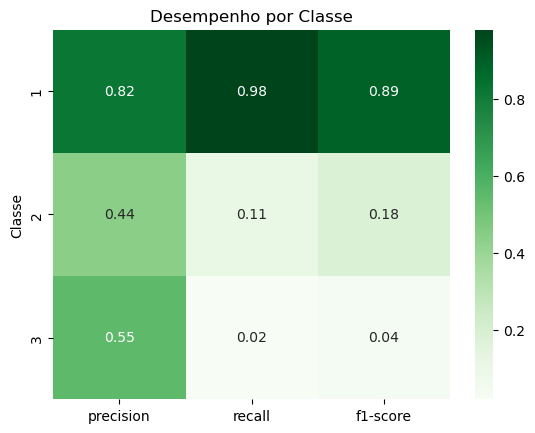


📌 Running Experiment 2/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'l1', 'class_weight': None}

🔧 Config: balance=None, normalize=zscore, penalty=l1, weight=None

📊 Classification Report
              precision    recall  f1-score   support

           1       0.82      0.98      0.89     13267
           2       0.44      0.12      0.18      2498
           3       0.53      0.02      0.04       768

    accuracy                           0.80     16533
   macro avg       0.60      0.37      0.37     16533
weighted avg       0.75      0.80      0.75     16533



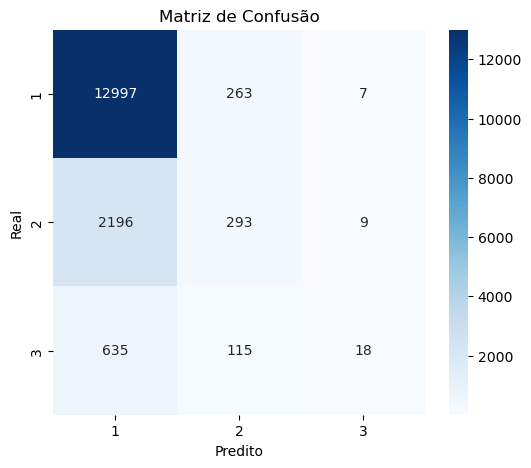

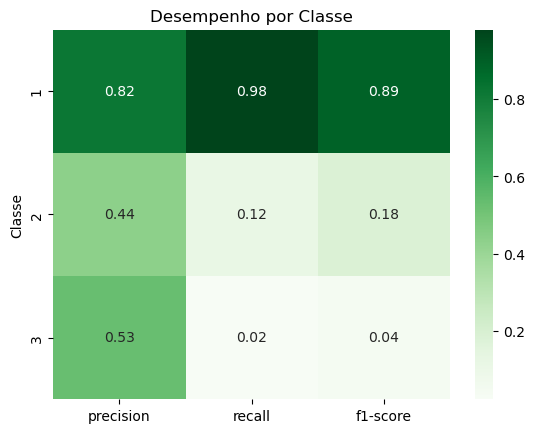


📌 Running Experiment 3/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=None, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

           1       0.82      0.98      0.89     13267
           2       0.43      0.12      0.18      2498
           3       0.50      0.02      0.04       768

    accuracy                           0.80     16533
   macro avg       0.59      0.37      0.37     16533
weighted avg       0.75      0.80      0.75     16533



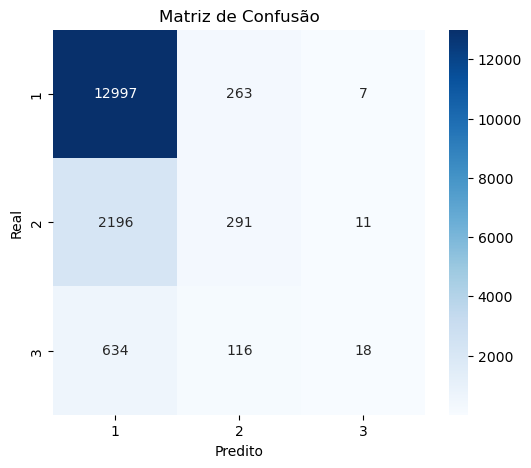

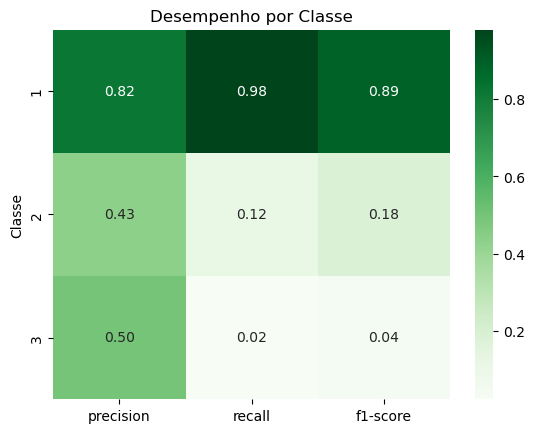


📌 Running Experiment 4/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'elasticnet', 'class_weight': None}

🔧 Config: balance=None, normalize=zscore, penalty=elasticnet, weight=None

📊 Classification Report
              precision    recall  f1-score   support

           1       0.82      0.98      0.89     13267
           2       0.44      0.12      0.18      2498
           3       0.41      0.03      0.06       768

    accuracy                           0.80     16533
   macro avg       0.56      0.38      0.38     16533
weighted avg       0.75      0.80      0.75     16533



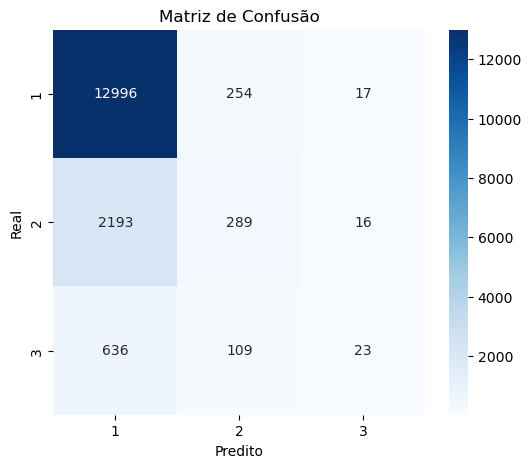

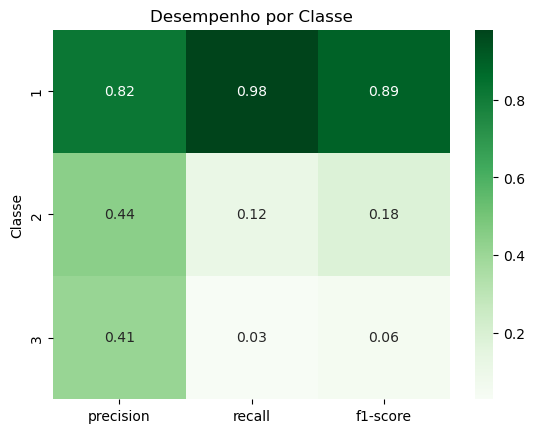


📌 Running Experiment 5/9
{'normalize': 'minmax', 'balance_strategy': None, 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=None, normalize=minmax, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

           1       0.82      0.98      0.89     13267
           2       0.44      0.12      0.18      2498
           3       0.54      0.02      0.04       768

    accuracy                           0.81     16533
   macro avg       0.60      0.37      0.37     16533
weighted avg       0.75      0.81      0.75     16533



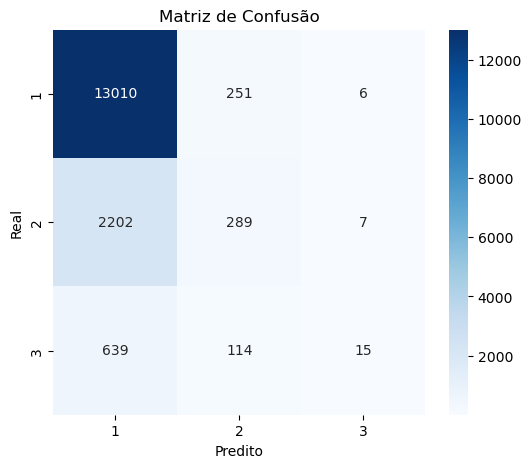

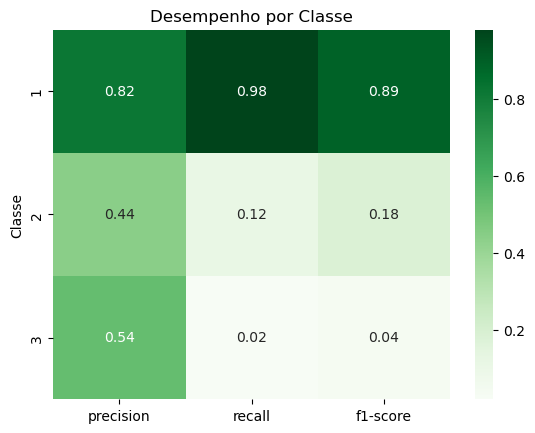


📌 Running Experiment 6/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'l2', 'class_weight': 'balanced'}

🔧 Config: balance=None, normalize=zscore, penalty=l2, weight=balanced

📊 Classification Report
              precision    recall  f1-score   support

           1       0.87      0.87      0.87     13267
           2       0.35      0.26      0.30      2498
           3       0.17      0.29      0.22       768

    accuracy                           0.75     16533
   macro avg       0.46      0.47      0.46     16533
weighted avg       0.76      0.75      0.75     16533



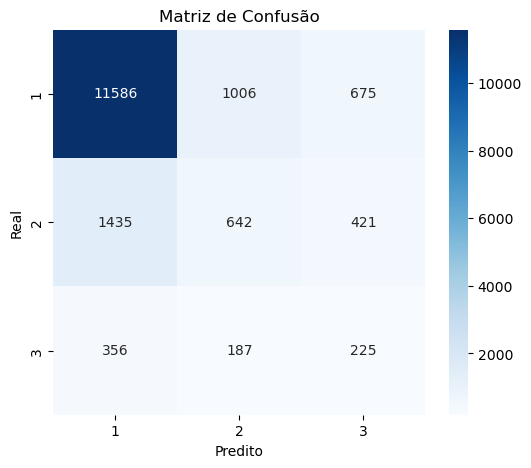

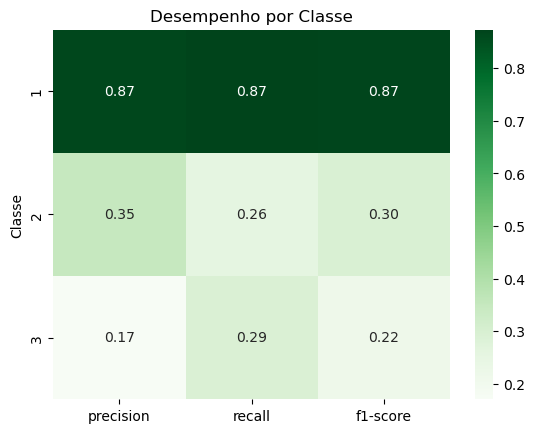


📌 Running Experiment 7/9
{'normalize': 'zscore', 'balance_strategy': 'smote', 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=smote, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

           1       0.89      0.74      0.81     13267
           2       0.27      0.33      0.30      2498
           3       0.13      0.40      0.19       768

    accuracy                           0.66     16533
   macro avg       0.43      0.49      0.43     16533
weighted avg       0.76      0.66      0.70     16533



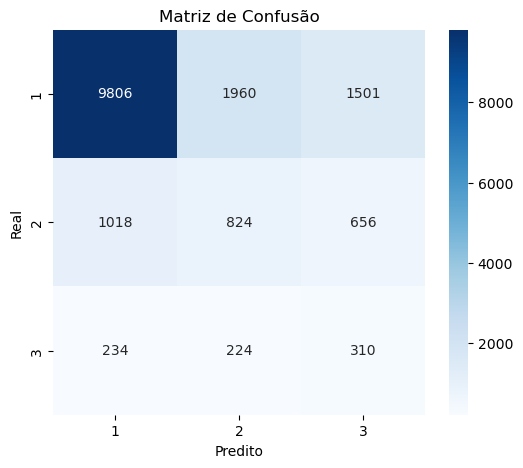

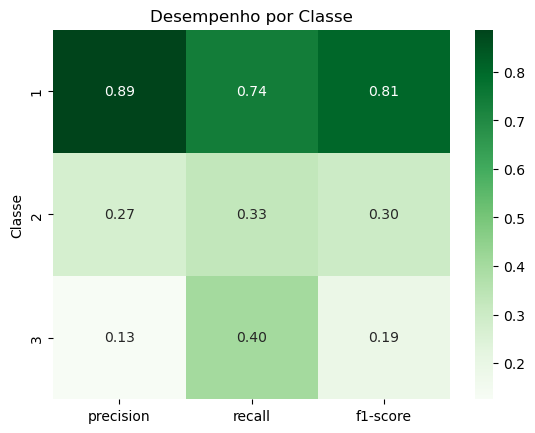


📌 Running Experiment 8/9
{'normalize': 'zscore', 'balance_strategy': 'ros', 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=ros, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

           1       0.91      0.70      0.79     13267
           2       0.27      0.34      0.30      2498
           3       0.13      0.53      0.20       768

    accuracy                           0.63     16533
   macro avg       0.43      0.52      0.43     16533
weighted avg       0.78      0.63      0.69     16533



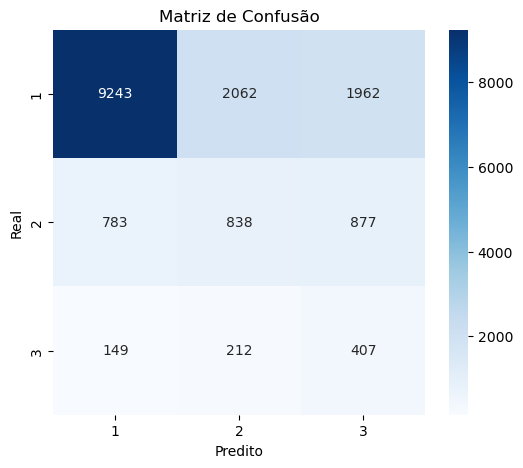

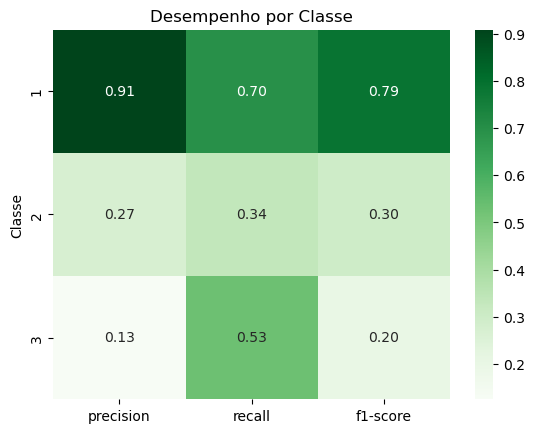


📌 Running Experiment 9/9
{'normalize': 'zscore', 'balance_strategy': 'rus', 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=rus, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

           1       0.91      0.66      0.77     13267
           2       0.24      0.33      0.28      2498
           3       0.12      0.52      0.20       768

    accuracy                           0.61     16533
   macro avg       0.42      0.51      0.41     16533
weighted avg       0.77      0.61      0.67     16533



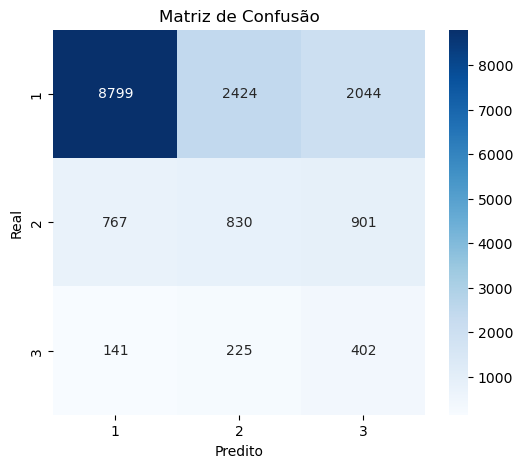

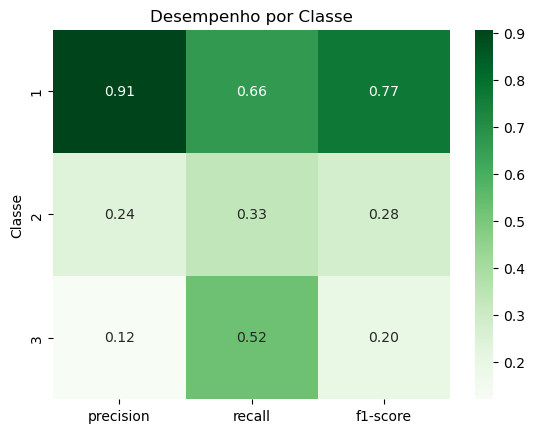

In [ ]:
results_regression_bow = []

solver_for_penalty = {
    "l1": "liblinear",
    "l2": "liblinear",
    "elasticnet": "saga"
}

for i, config in enumerate(experiment_configs):
    print(f"\n📌 Running Experiment {i+1}/{len(experiment_configs)}")
    print(config)

    # Dynamically assign solver and l1_ratio
    penalty = config["penalty"]
    solver = solver_for_penalty[penalty]
    l1_ratio = 0.5 if penalty == "elasticnet" else None

    report_dict = run_logistic_experiment(
        X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test,
        normalize=config["normalize"],
        balance_strategy=config["balance_strategy"],
        penalty=penalty,
        solver=solver,
        class_weight=config["class_weight"],
        l1_ratio=l1_ratio,
        verbose=False
    )

    macro_f1 = report_dict["macro avg"]["f1-score"]

    most_viral_class = str(max(np.unique(y_tfidf_test)))
    viral_f1 = report_dict.get(most_viral_class, {}).get("f1-score", 0.0)

    results_regression_bow.append({
        **config,
        "solver": solver,
        "l1_ratio": l1_ratio,
        "macro_f1": macro_f1,
        "viral_f1": viral_f1
    })


##### Word2Vec


📌 Running Experiment 1/9
{'normalize': None, 'balance_strategy': None, 'penalty': 'l1', 'class_weight': None}

🔧 Config: balance=None, normalize=None, penalty=l1, weight=None

📊 Classification Report
              precision    recall  f1-score   support

           1       0.82      0.98      0.89     13267
           2       0.44      0.11      0.18      2498
           3       0.55      0.02      0.04       768

    accuracy                           0.81     16533
   macro avg       0.60      0.37      0.37     16533
weighted avg       0.75      0.81      0.75     16533



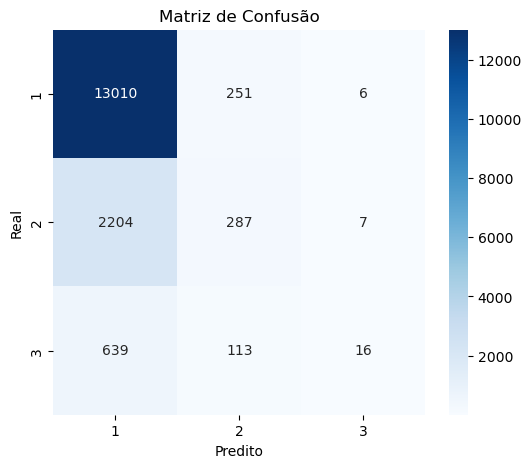

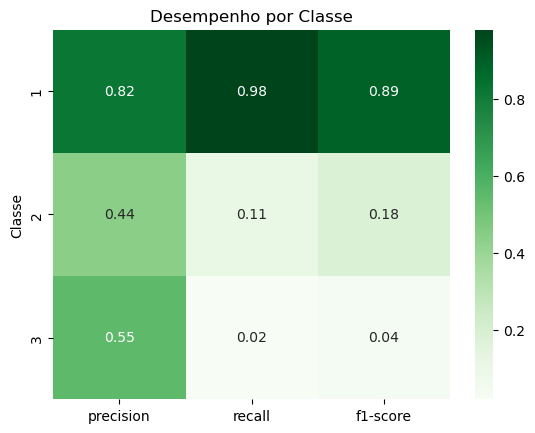


📌 Running Experiment 2/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'l1', 'class_weight': None}

🔧 Config: balance=None, normalize=zscore, penalty=l1, weight=None

📊 Classification Report
              precision    recall  f1-score   support

           1       0.82      0.98      0.89     13267
           2       0.44      0.12      0.18      2498
           3       0.53      0.02      0.04       768

    accuracy                           0.80     16533
   macro avg       0.60      0.37      0.37     16533
weighted avg       0.75      0.80      0.75     16533



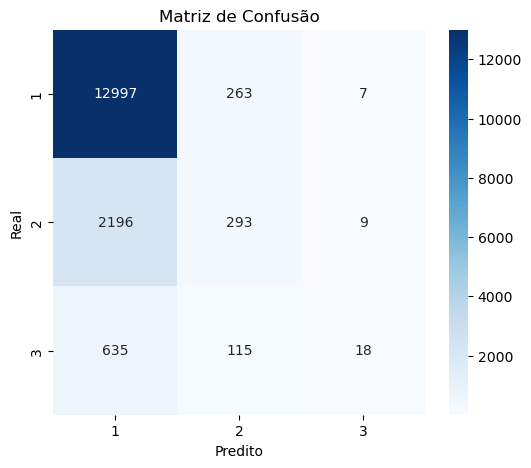

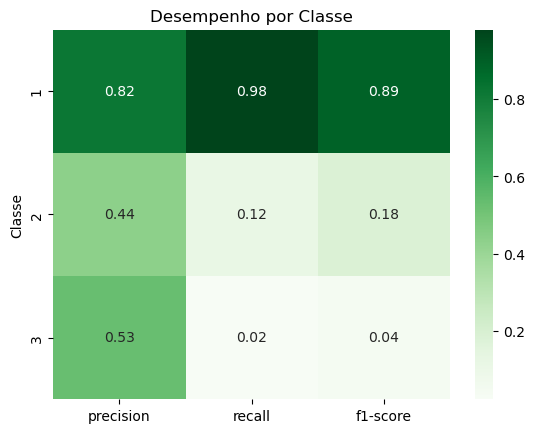


📌 Running Experiment 3/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=None, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

           1       0.82      0.98      0.89     13267
           2       0.43      0.12      0.18      2498
           3       0.50      0.02      0.04       768

    accuracy                           0.80     16533
   macro avg       0.59      0.37      0.37     16533
weighted avg       0.75      0.80      0.75     16533



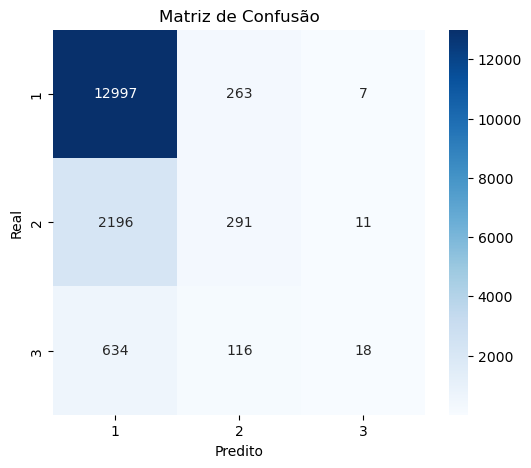

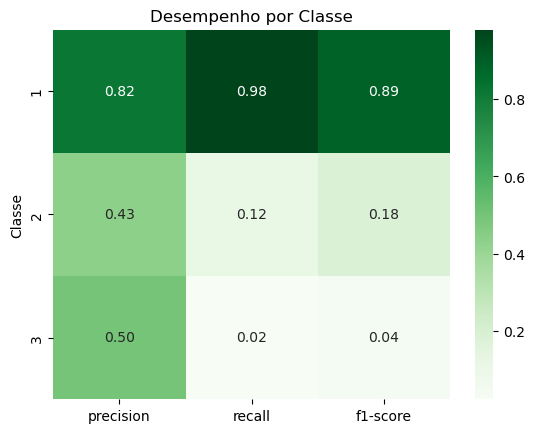


📌 Running Experiment 4/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'elasticnet', 'class_weight': None}

🔧 Config: balance=None, normalize=zscore, penalty=elasticnet, weight=None

📊 Classification Report
              precision    recall  f1-score   support

           1       0.82      0.98      0.89     13267
           2       0.44      0.12      0.18      2498
           3       0.41      0.03      0.06       768

    accuracy                           0.80     16533
   macro avg       0.56      0.38      0.38     16533
weighted avg       0.75      0.80      0.75     16533



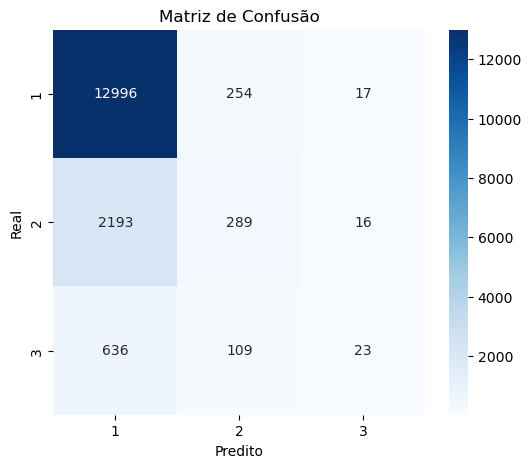

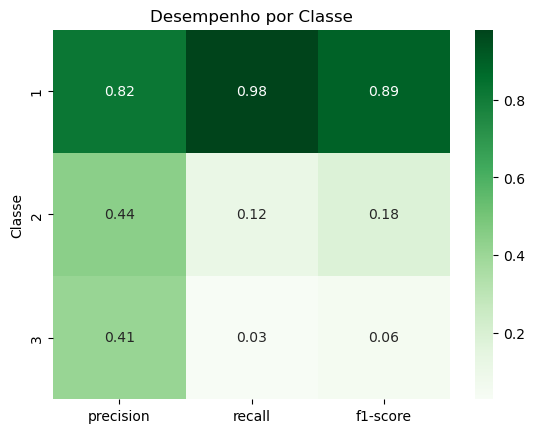


📌 Running Experiment 5/9
{'normalize': 'minmax', 'balance_strategy': None, 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=None, normalize=minmax, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

           1       0.82      0.98      0.89     13267
           2       0.44      0.12      0.18      2498
           3       0.54      0.02      0.04       768

    accuracy                           0.81     16533
   macro avg       0.60      0.37      0.37     16533
weighted avg       0.75      0.81      0.75     16533



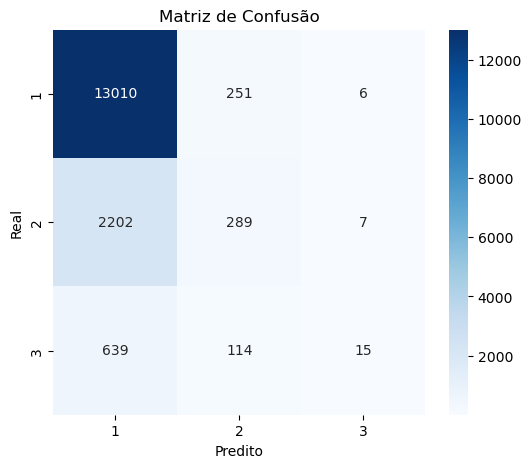

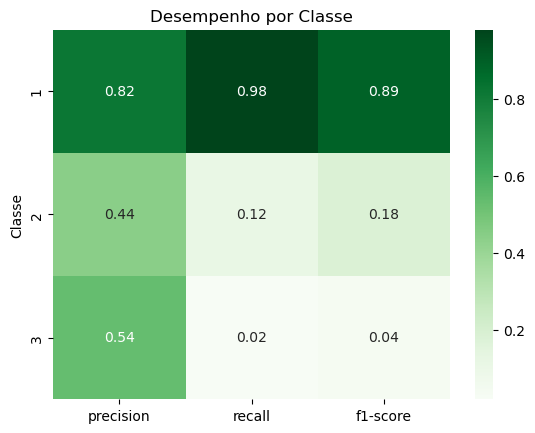


📌 Running Experiment 6/9
{'normalize': 'zscore', 'balance_strategy': None, 'penalty': 'l2', 'class_weight': 'balanced'}

🔧 Config: balance=None, normalize=zscore, penalty=l2, weight=balanced

📊 Classification Report
              precision    recall  f1-score   support

           1       0.87      0.87      0.87     13267
           2       0.35      0.26      0.30      2498
           3       0.17      0.29      0.22       768

    accuracy                           0.75     16533
   macro avg       0.46      0.47      0.46     16533
weighted avg       0.76      0.75      0.75     16533



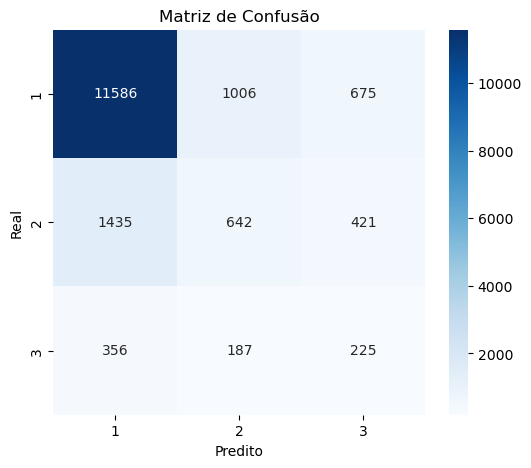

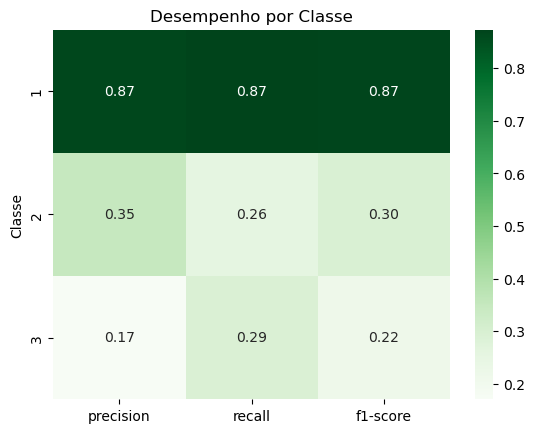


📌 Running Experiment 7/9
{'normalize': 'zscore', 'balance_strategy': 'smote', 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=smote, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

           1       0.89      0.74      0.81     13267
           2       0.27      0.33      0.30      2498
           3       0.13      0.40      0.19       768

    accuracy                           0.66     16533
   macro avg       0.43      0.49      0.43     16533
weighted avg       0.76      0.66      0.70     16533



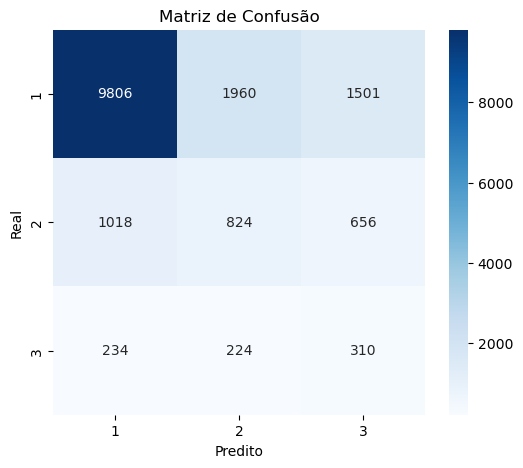

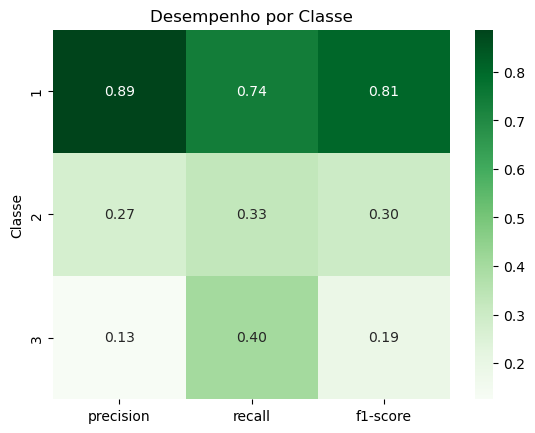


📌 Running Experiment 8/9
{'normalize': 'zscore', 'balance_strategy': 'ros', 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=ros, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

           1       0.91      0.70      0.79     13267
           2       0.27      0.34      0.30      2498
           3       0.13      0.53      0.20       768

    accuracy                           0.63     16533
   macro avg       0.43      0.52      0.43     16533
weighted avg       0.78      0.63      0.69     16533



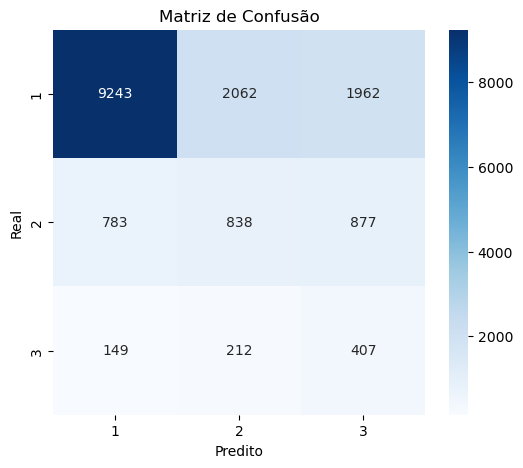

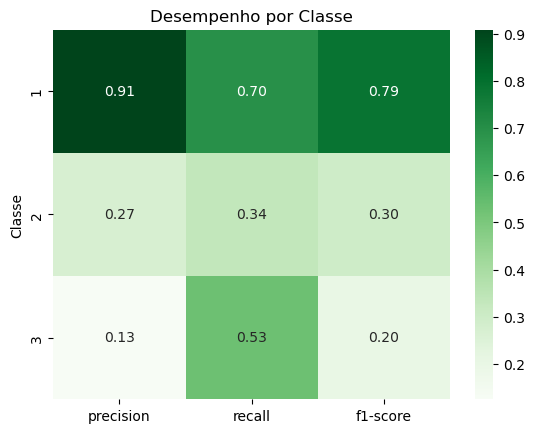


📌 Running Experiment 9/9
{'normalize': 'zscore', 'balance_strategy': 'rus', 'penalty': 'l2', 'class_weight': None}

🔧 Config: balance=rus, normalize=zscore, penalty=l2, weight=None

📊 Classification Report
              precision    recall  f1-score   support

           1       0.91      0.66      0.77     13267
           2       0.24      0.33      0.28      2498
           3       0.12      0.52      0.20       768

    accuracy                           0.61     16533
   macro avg       0.42      0.51      0.41     16533
weighted avg       0.77      0.61      0.67     16533



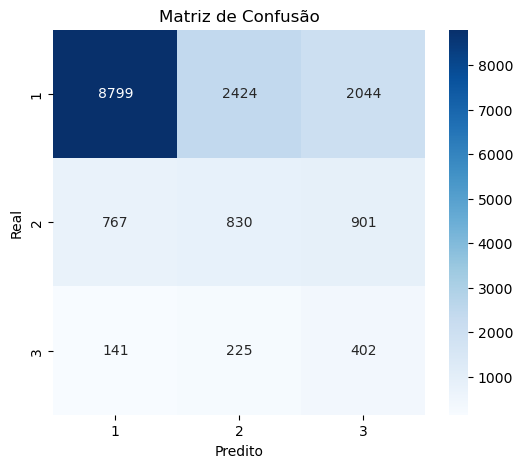

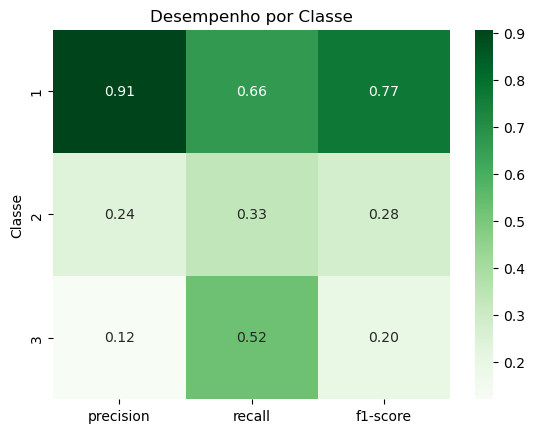

In [ ]:
results_regression_word2vec = []

solver_for_penalty = {
    "l1": "liblinear",
    "l2": "liblinear",
    "elasticnet": "saga"
}

for i, config in enumerate(experiment_configs):
    print(f"\n📌 Running Experiment {i+1}/{len(experiment_configs)}")
    print(config)

    # Dynamically assign solver and l1_ratio
    penalty = config["penalty"]
    solver = solver_for_penalty[penalty]
    l1_ratio = 0.5 if penalty == "elasticnet" else None

    report_dict = run_logistic_experiment(
        X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test,
        normalize=config["normalize"],
        balance_strategy=config["balance_strategy"],
        penalty=penalty,
        solver=solver,
        class_weight=config["class_weight"],
        l1_ratio=l1_ratio,
        verbose=False
    )

    macro_f1 = report_dict["macro avg"]["f1-score"]

    most_viral_class = str(max(np.unique(y_tfidf_test)))
    viral_f1 = report_dict.get(most_viral_class, {}).get("f1-score", 0.0)

    results_regression_word2vec.append({
        **config,
        "solver": solver,
        "l1_ratio": l1_ratio,
        "macro_f1": macro_f1,
        "viral_f1": viral_f1
    })


#### Árvore de Decisão

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, label_binarize


def run_decision_tree_experiment(
    X_train, X_test, y_train, y_test,
    balance_strategy=None,
    normalize=None,
    class_weight=None,
    max_depth=None,
    random_state=42,
    verbose=True
):
    print(f"\n🔧 Config DT: balance={balance_strategy}, normalize={normalize}, class_weight={class_weight}, max_depth={max_depth}")
    
    # Normalização
    if normalize == "zscore":
        scaler = StandardScaler()
    elif normalize == "minmax":
        scaler = MinMaxScaler()
    else:
        scaler = None
    if scaler:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # Balanceamento
    if balance_strategy == "smote":
        sampler = SMOTE(random_state=random_state)
    elif balance_strategy == "ros":
        sampler = RandomOverSampler(random_state=random_state)
    elif balance_strategy == "rus":
        sampler = RandomUnderSampler(random_state=random_state)
    else:
        sampler = None
    if sampler:
        X_train, y_train = sampler.fit_resample(X_train, y_train)

    # Treina modelo
    model = DecisionTreeClassifier(
        class_weight=class_weight,
        max_depth=max_depth,
        random_state=random_state
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    
    # Definir classes e nomes
    class_labels = sorted(np.unique(y_test))
    target_names = [str(c) for c in class_labels]  # Se quiser nomes customizados, pode passar aqui

    # Obtém classification_report como dict
    report_dict = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    
    if verbose:
        print("\n📊 Classification Report")
        print(classification_report(y_test, y_pred, target_names=target_names))

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred, labels=class_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.title("Matriz de Confusão")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

    # Curva ROC (somente binário)
    if len(class_labels) == 2 and hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (área = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel("Falso Positivo (FPR)")
        plt.ylabel("Verdadeiro Positivo (TPR)")
        plt.title("Curva ROC")
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()

    # Heatmap das métricas (precision, recall, f1-score)
    metrics_to_plot = ["precision", "recall", "f1-score"]
    df_plot = pd.DataFrame(report_dict).transpose().loc[target_names, metrics_to_plot]
    plt.figure(figsize=(8, len(target_names) * 0.6 + 2))
    sns.heatmap(df_plot, annot=True, fmt=".2f", cmap="Greens")
    plt.title("Desempenho por Classe")
    plt.ylabel("Classe")
    plt.show()

    return report_dict

In [43]:
dt_experiment_configs = [
    # Baseline
    {"normalize": None, "balance_strategy": None, "max_depth": None, "class_weight": None},

    # Variação de normalização
    {"normalize": "zscore", "balance_strategy": None, "max_depth": None, "class_weight": None},
    {"normalize": "minmax", "balance_strategy": None, "max_depth": None, "class_weight": None},

    # Class weighting
    {"normalize": "zscore", "balance_strategy": None, "max_depth": None, "class_weight": "balanced"},

    # Com balanceamento
    {"normalize": "zscore", "balance_strategy": "smote", "max_depth": None, "class_weight": None},
    {"normalize": "zscore", "balance_strategy": "ros", "max_depth": None, "class_weight": None},
    {"normalize": "zscore", "balance_strategy": "rus", "max_depth": None, "class_weight": None},

    # Testando profundidades diferentes
    {"normalize": "zscore", "balance_strategy": None, "max_depth": 5, "class_weight": None},
    {"normalize": "zscore", "balance_strategy": None, "max_depth": 10, "class_weight": None},
    {"normalize": "zscore", "balance_strategy": None, "max_depth": 20, "class_weight": None},
]

##### TF-IDF


📌 Running Experiment 1/10
{'normalize': None, 'balance_strategy': None, 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=None, normalize=None, class_weight=None, max_depth=None


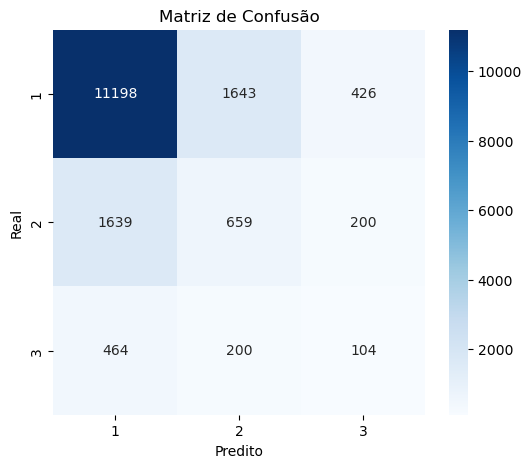

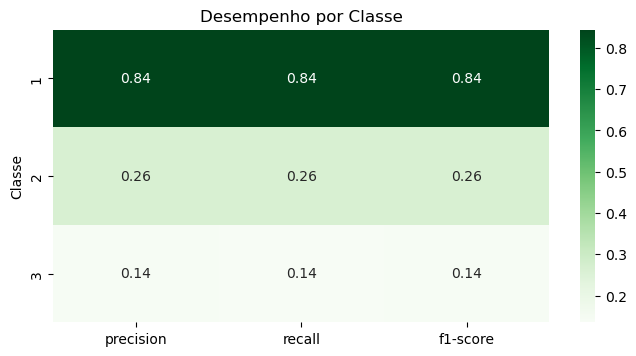


📌 Running Experiment 2/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=None, normalize=zscore, class_weight=None, max_depth=None


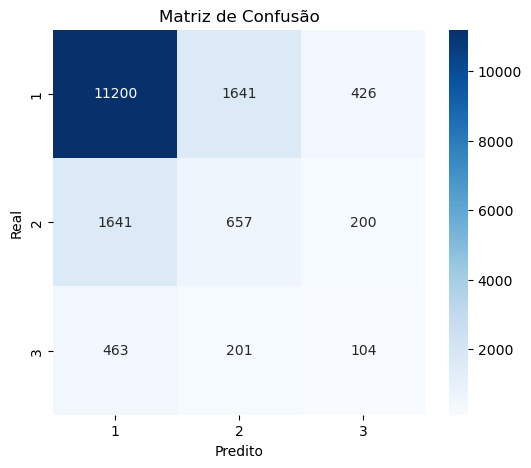

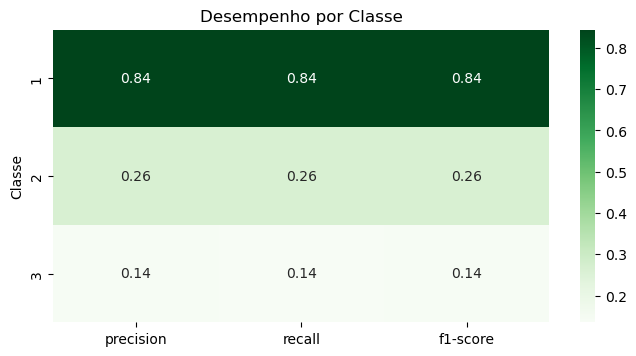


📌 Running Experiment 3/10
{'normalize': 'minmax', 'balance_strategy': None, 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=None, normalize=minmax, class_weight=None, max_depth=None


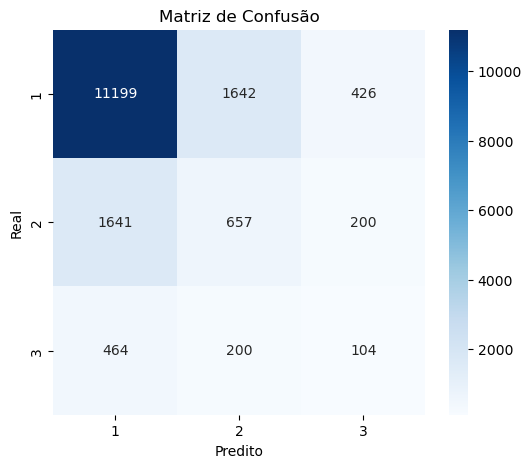

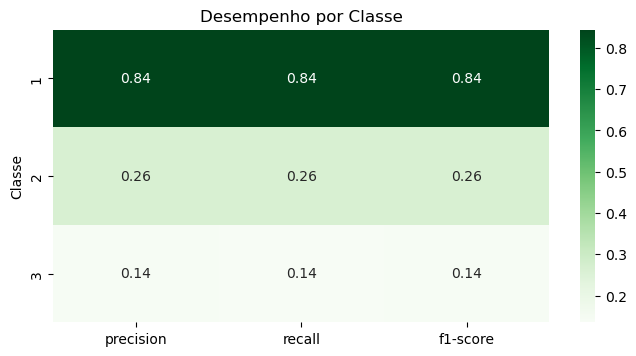


📌 Running Experiment 4/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': None, 'class_weight': 'balanced'}

🔧 Config DT: balance=None, normalize=zscore, class_weight=balanced, max_depth=None


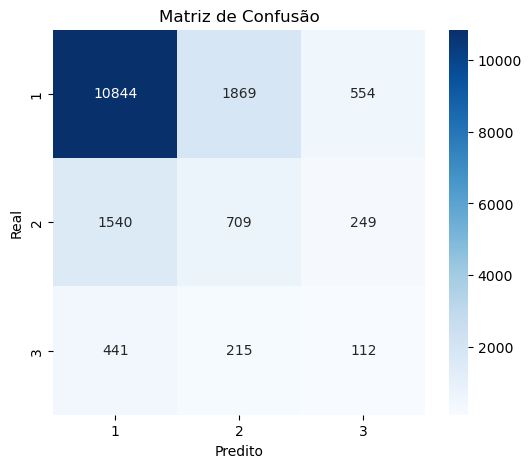

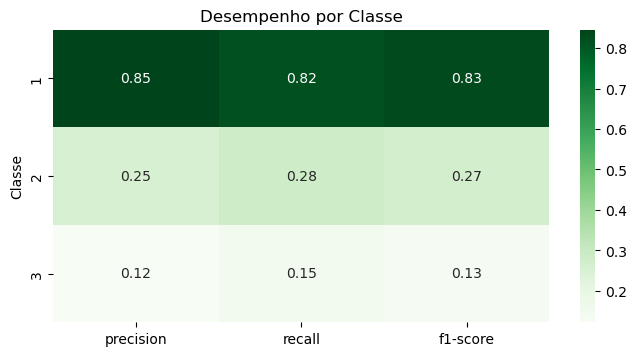


📌 Running Experiment 5/10
{'normalize': 'zscore', 'balance_strategy': 'smote', 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=smote, normalize=zscore, class_weight=None, max_depth=None


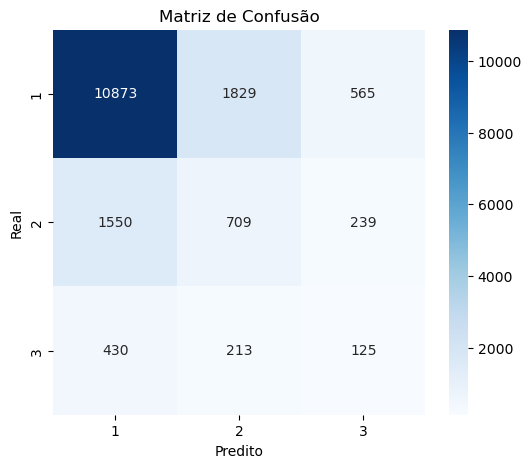

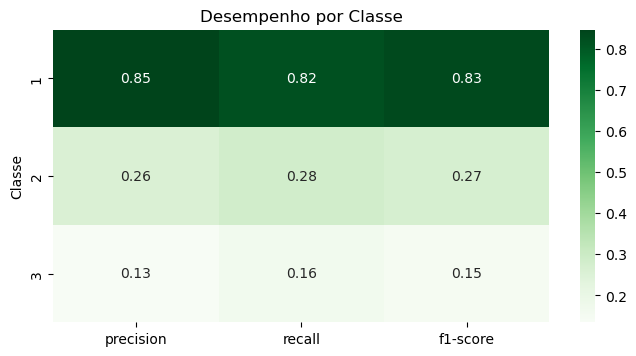


📌 Running Experiment 6/10
{'normalize': 'zscore', 'balance_strategy': 'ros', 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=ros, normalize=zscore, class_weight=None, max_depth=None


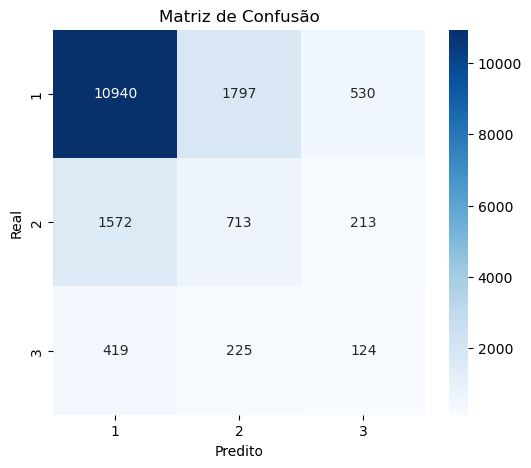

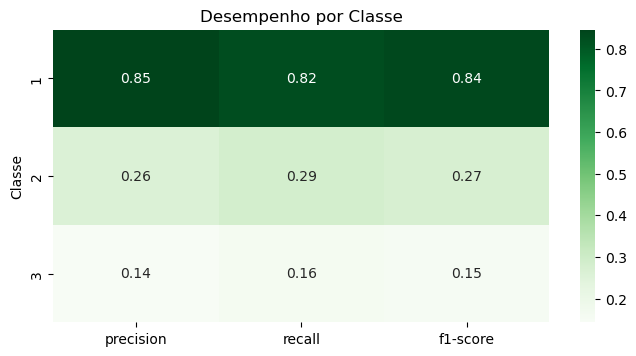


📌 Running Experiment 7/10
{'normalize': 'zscore', 'balance_strategy': 'rus', 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=rus, normalize=zscore, class_weight=None, max_depth=None


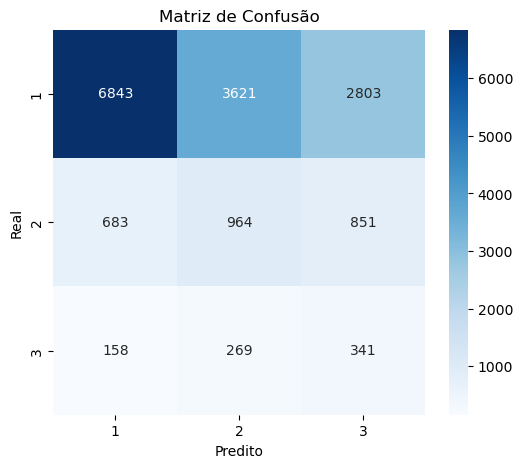

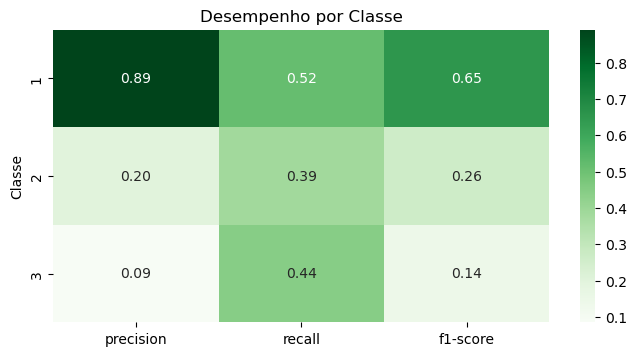


📌 Running Experiment 8/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': 5, 'class_weight': None}

🔧 Config DT: balance=None, normalize=zscore, class_weight=None, max_depth=5


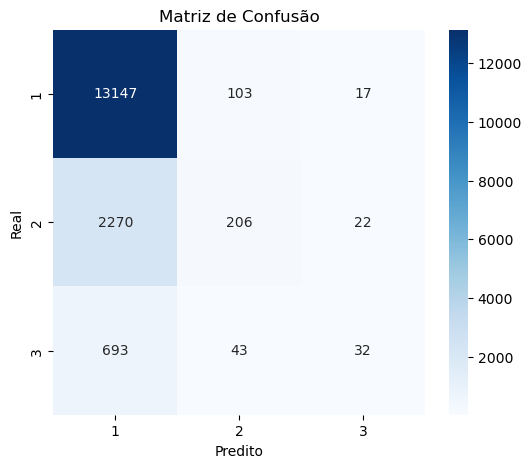

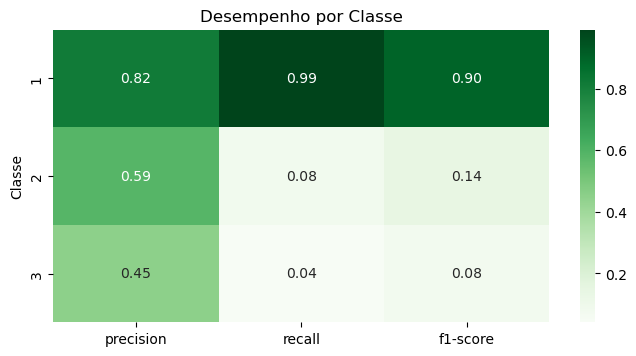


📌 Running Experiment 9/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': 10, 'class_weight': None}

🔧 Config DT: balance=None, normalize=zscore, class_weight=None, max_depth=10


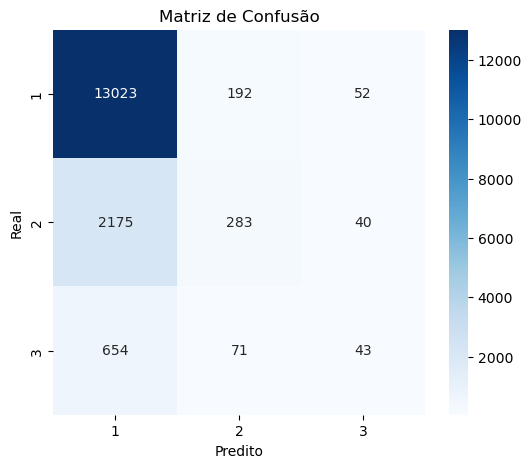

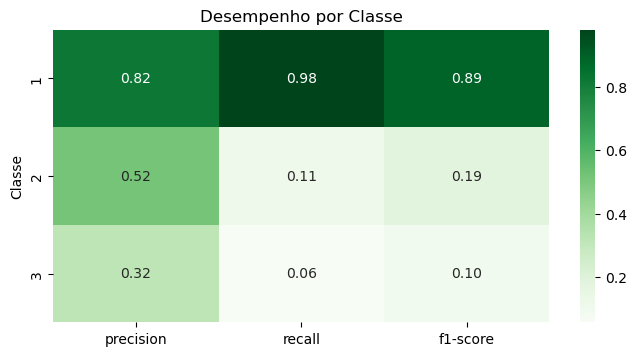


📌 Running Experiment 10/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': 20, 'class_weight': None}

🔧 Config DT: balance=None, normalize=zscore, class_weight=None, max_depth=20


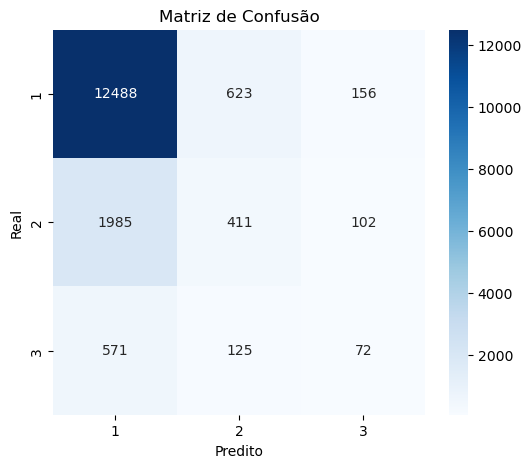

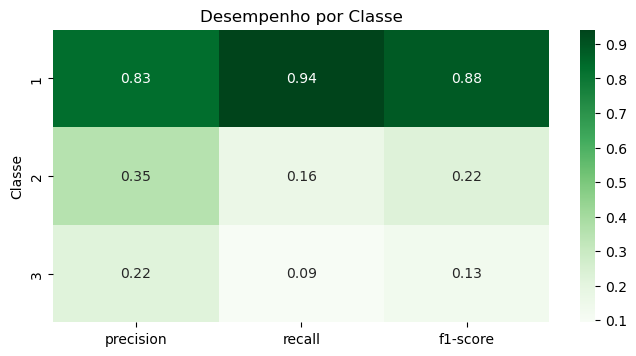

In [45]:
results_decision_tree_tfidf = []

for i, config in enumerate(dt_experiment_configs):
    print(f"\n📌 Running Experiment {i+1}/{len(dt_experiment_configs)}")
    print(config)

    report_dict = run_decision_tree_experiment(
        X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test,
        normalize=config["normalize"],
        balance_strategy=config["balance_strategy"],
        max_depth=config["max_depth"],
        class_weight=config["class_weight"],
        verbose=False
    )

    # Store results
    macro_f1 = report_dict["macro avg"]["f1-score"]
    most_viral_class = str(max(np.unique(y_tfidf_test)))
    viral_f1 = report_dict.get(most_viral_class, {}).get("f1-score", 0.0)
    results_decision_tree_tfidf.append({
        **config,
        "macro_f1": macro_f1,
        "viral_f1": viral_f1
    })

##### BOW


📌 Running Experiment 1/10
{'normalize': None, 'balance_strategy': None, 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=None, normalize=None, class_weight=None, max_depth=None


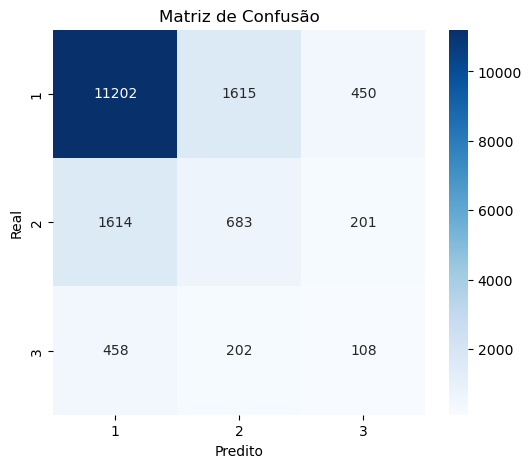

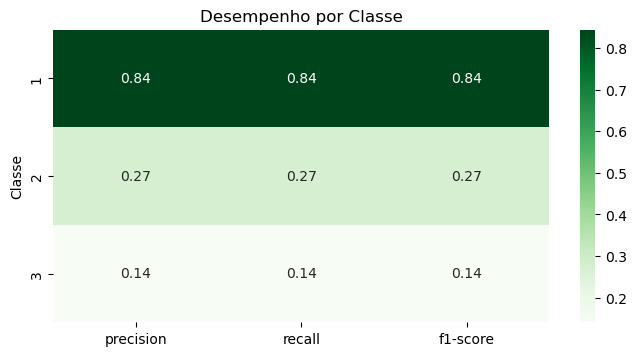


📌 Running Experiment 2/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=None, normalize=zscore, class_weight=None, max_depth=None


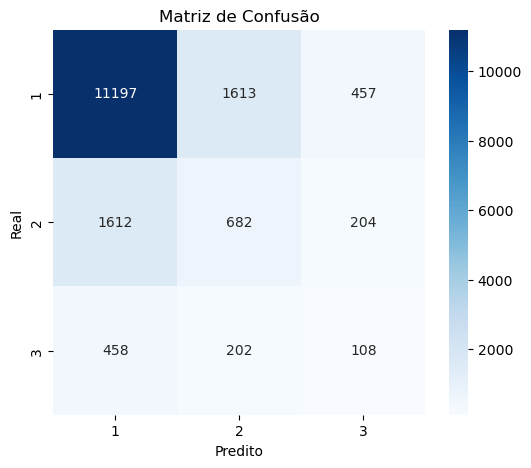

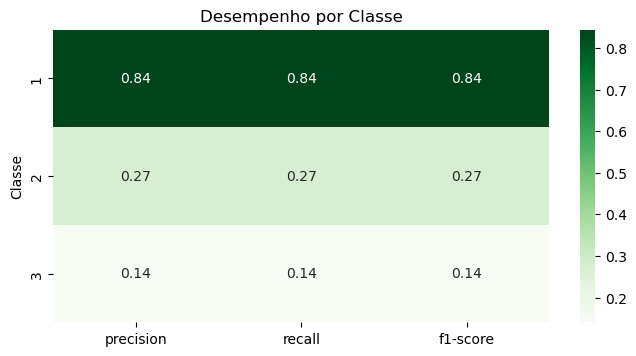


📌 Running Experiment 3/10
{'normalize': 'minmax', 'balance_strategy': None, 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=None, normalize=minmax, class_weight=None, max_depth=None


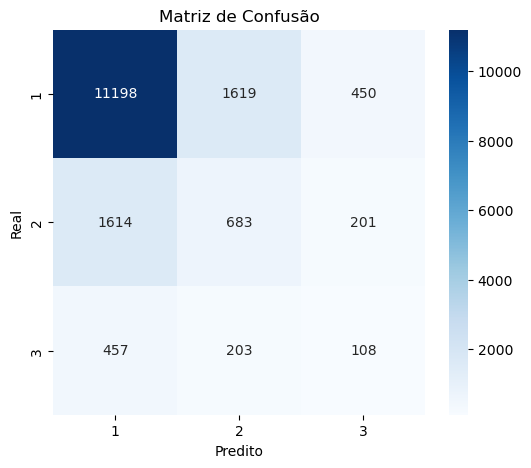

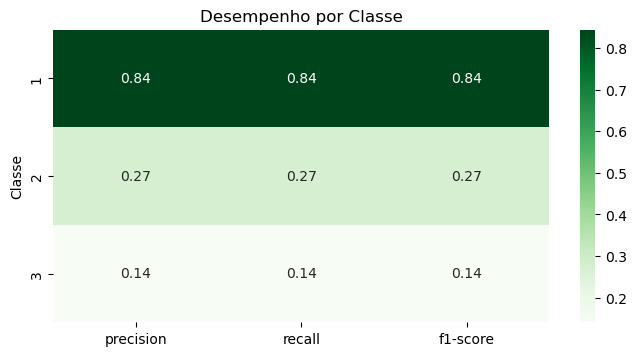


📌 Running Experiment 4/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': None, 'class_weight': 'balanced'}

🔧 Config DT: balance=None, normalize=zscore, class_weight=balanced, max_depth=None


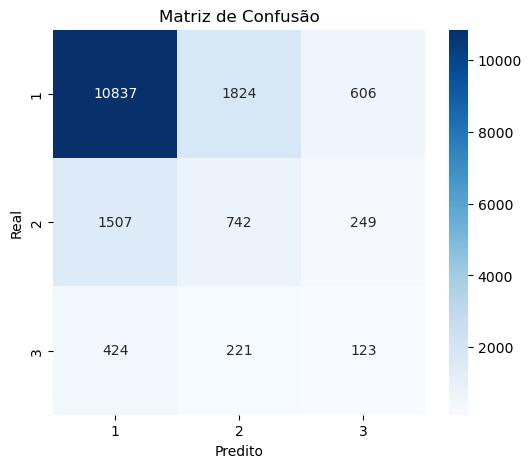

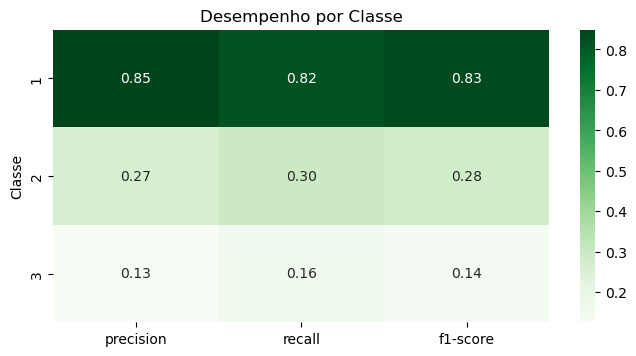


📌 Running Experiment 5/10
{'normalize': 'zscore', 'balance_strategy': 'smote', 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=smote, normalize=zscore, class_weight=None, max_depth=None


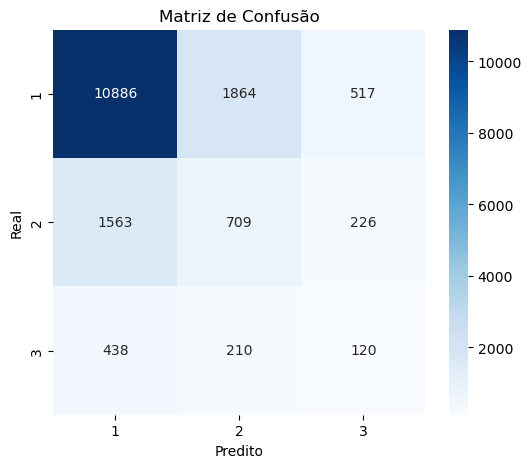

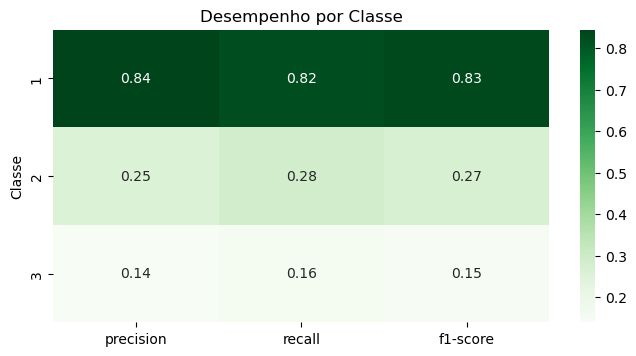


📌 Running Experiment 6/10
{'normalize': 'zscore', 'balance_strategy': 'ros', 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=ros, normalize=zscore, class_weight=None, max_depth=None


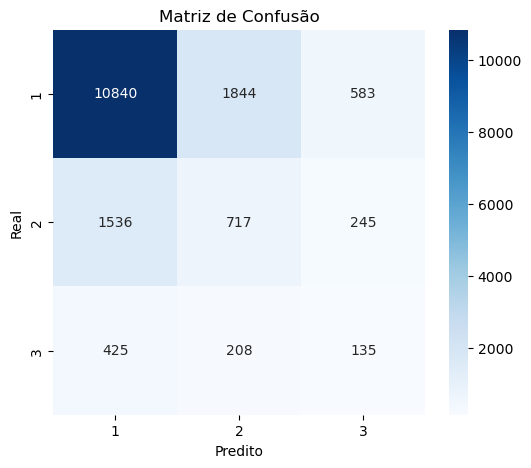

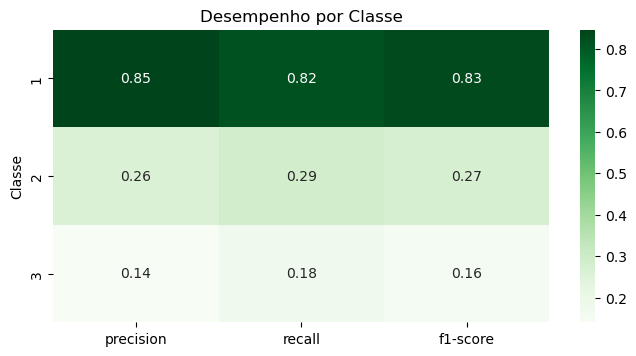


📌 Running Experiment 7/10
{'normalize': 'zscore', 'balance_strategy': 'rus', 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=rus, normalize=zscore, class_weight=None, max_depth=None


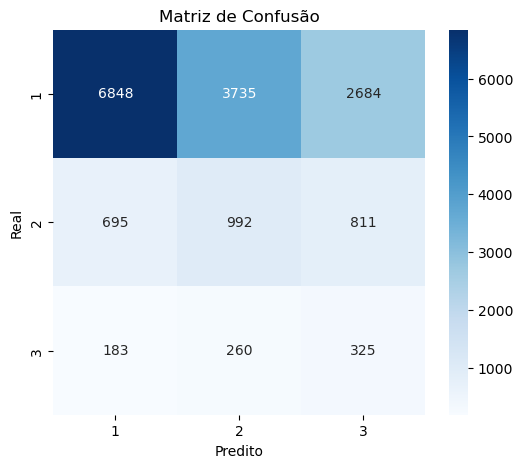

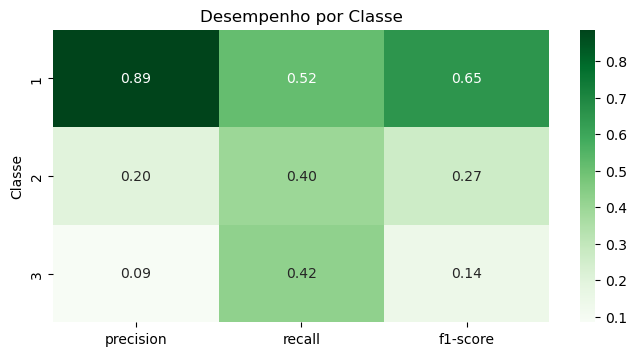


📌 Running Experiment 8/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': 5, 'class_weight': None}

🔧 Config DT: balance=None, normalize=zscore, class_weight=None, max_depth=5


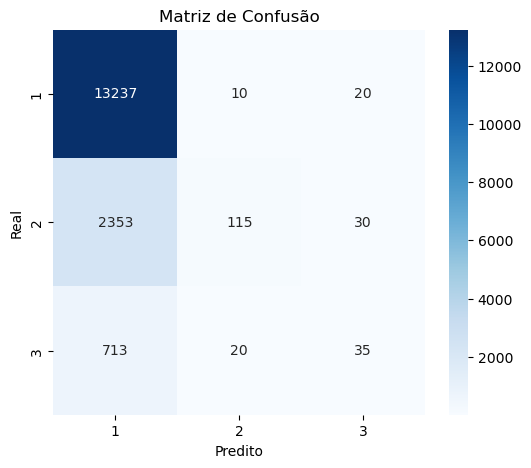

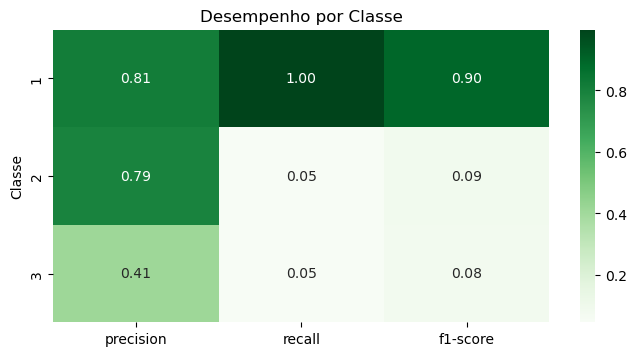


📌 Running Experiment 9/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': 10, 'class_weight': None}

🔧 Config DT: balance=None, normalize=zscore, class_weight=None, max_depth=10


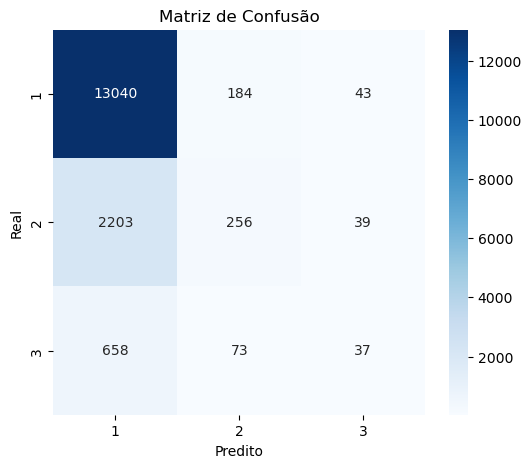

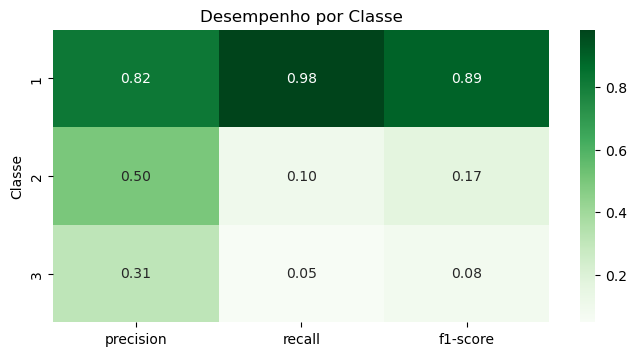


📌 Running Experiment 10/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': 20, 'class_weight': None}

🔧 Config DT: balance=None, normalize=zscore, class_weight=None, max_depth=20


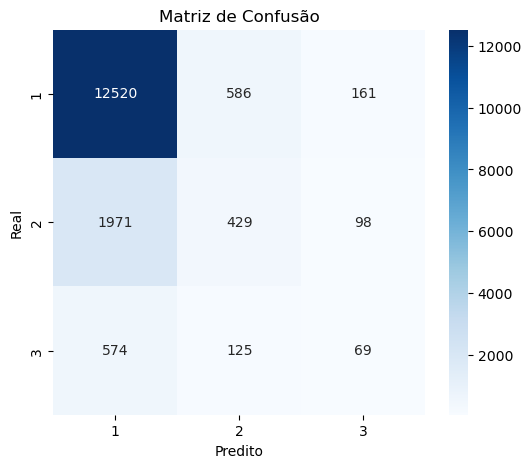

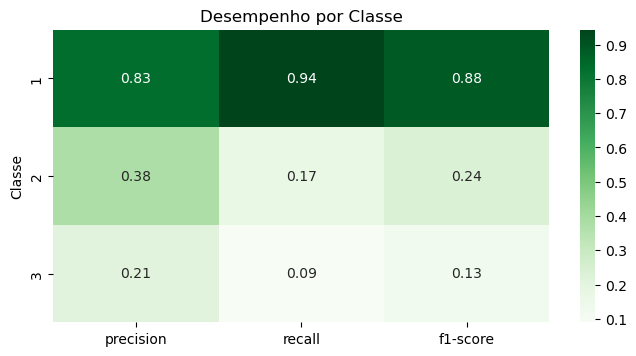

In [46]:
results_decision_tree_bow = []

for i, config in enumerate(dt_experiment_configs):
    print(f"\n📌 Running Experiment {i+1}/{len(dt_experiment_configs)}")
    print(config)

    report_dict = run_decision_tree_experiment(
        X_bow_train, X_bow_test, y_bow_train, y_bow_test,
        normalize=config["normalize"],
        balance_strategy=config["balance_strategy"],
        max_depth=config["max_depth"],
        class_weight=config["class_weight"],
        verbose=False
    )

    # Store results
    macro_f1 = report_dict["macro avg"]["f1-score"]
    most_viral_class = str(max(np.unique(y_bow_test)))
    viral_f1 = report_dict.get(most_viral_class, {}).get("f1-score", 0.0)
    results_decision_tree_bow.append({
        **config,
        "macro_f1": macro_f1,
        "viral_f1": viral_f1
    })

##### Word2Vec


📌 Running Experiment 1/10
{'normalize': None, 'balance_strategy': None, 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=None, normalize=None, class_weight=None, max_depth=None


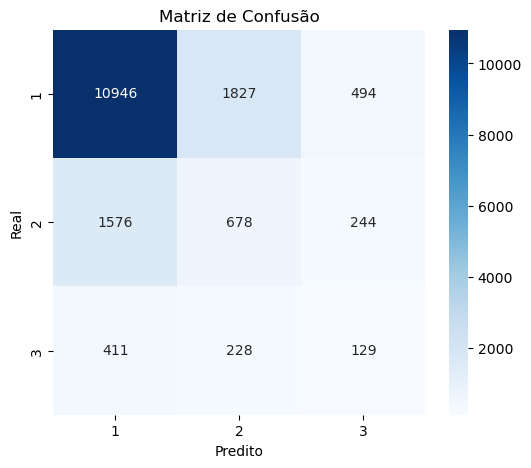

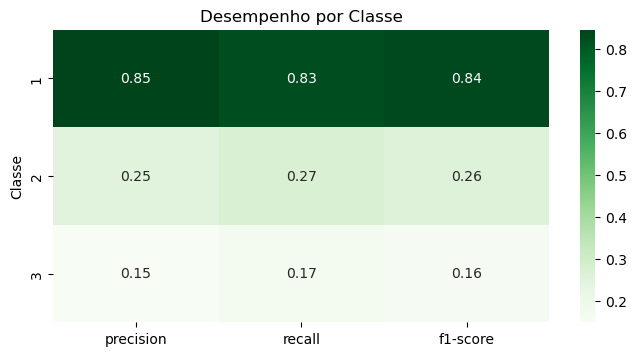


📌 Running Experiment 2/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=None, normalize=zscore, class_weight=None, max_depth=None


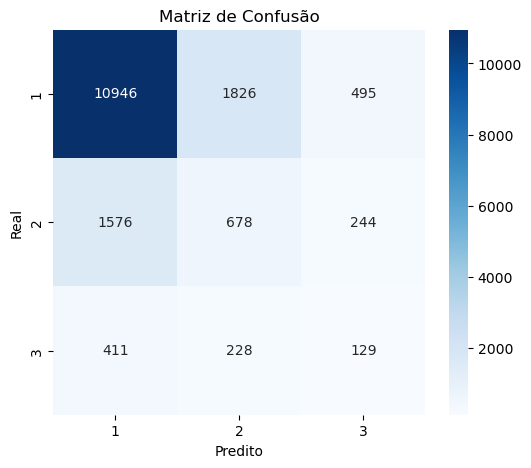

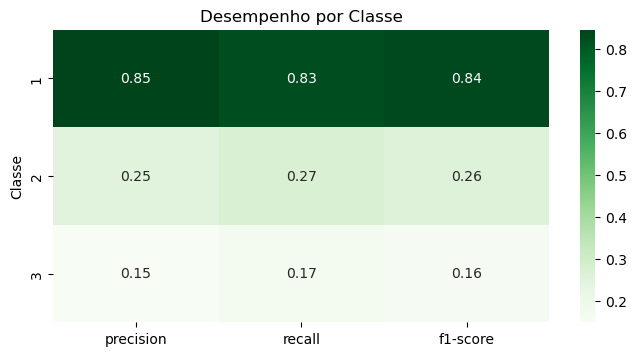


📌 Running Experiment 3/10
{'normalize': 'minmax', 'balance_strategy': None, 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=None, normalize=minmax, class_weight=None, max_depth=None


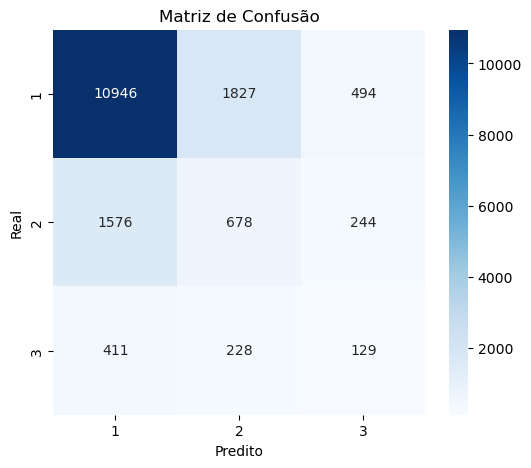

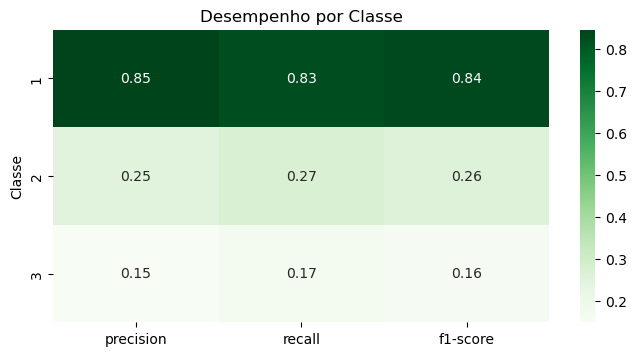


📌 Running Experiment 4/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': None, 'class_weight': 'balanced'}

🔧 Config DT: balance=None, normalize=zscore, class_weight=balanced, max_depth=None


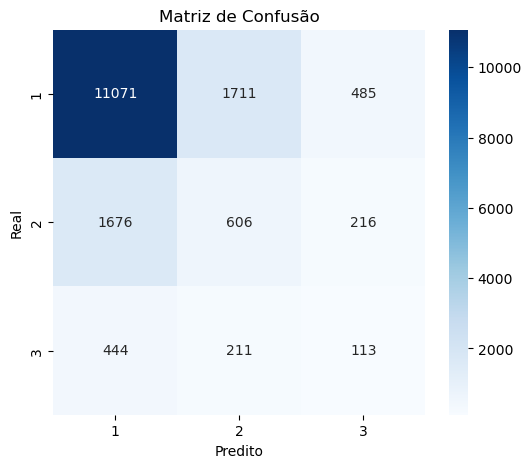

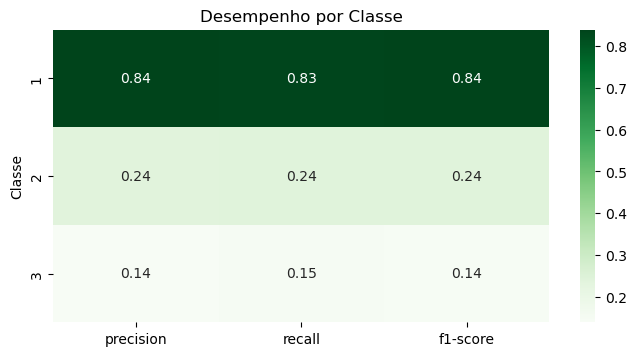


📌 Running Experiment 5/10
{'normalize': 'zscore', 'balance_strategy': 'smote', 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=smote, normalize=zscore, class_weight=None, max_depth=None


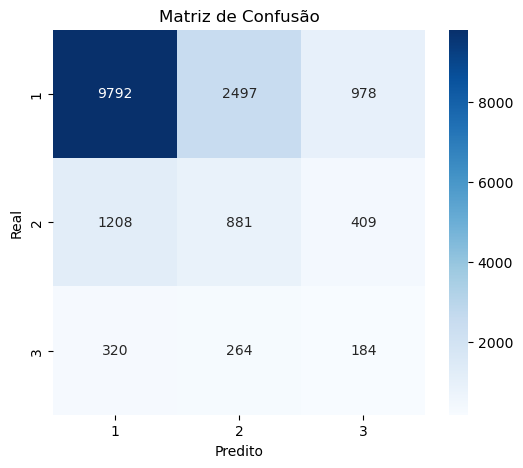

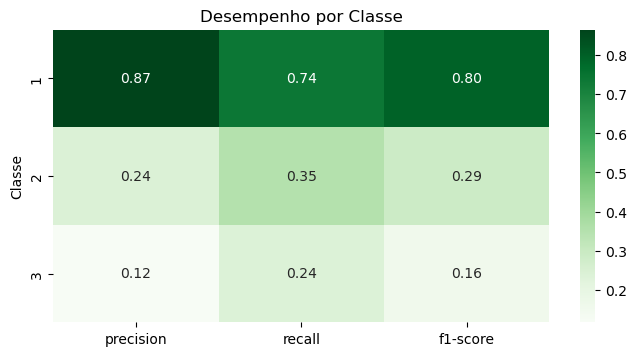


📌 Running Experiment 6/10
{'normalize': 'zscore', 'balance_strategy': 'ros', 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=ros, normalize=zscore, class_weight=None, max_depth=None


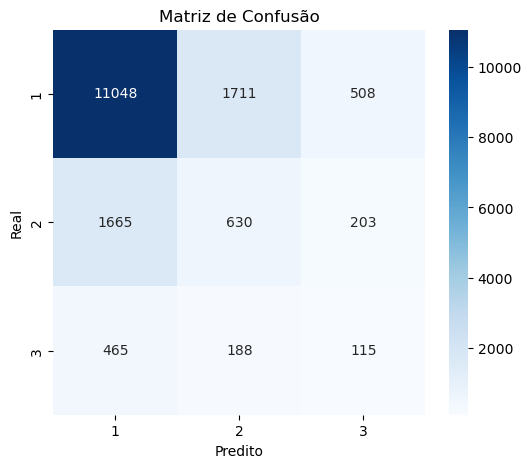

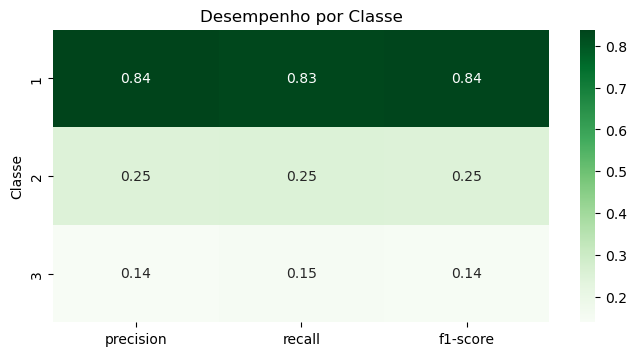


📌 Running Experiment 7/10
{'normalize': 'zscore', 'balance_strategy': 'rus', 'max_depth': None, 'class_weight': None}

🔧 Config DT: balance=rus, normalize=zscore, class_weight=None, max_depth=None


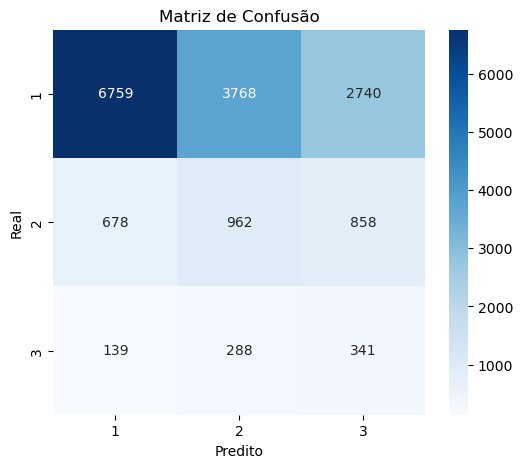

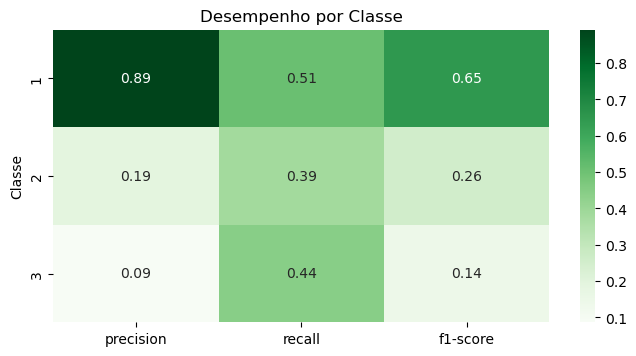


📌 Running Experiment 8/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': 5, 'class_weight': None}

🔧 Config DT: balance=None, normalize=zscore, class_weight=None, max_depth=5


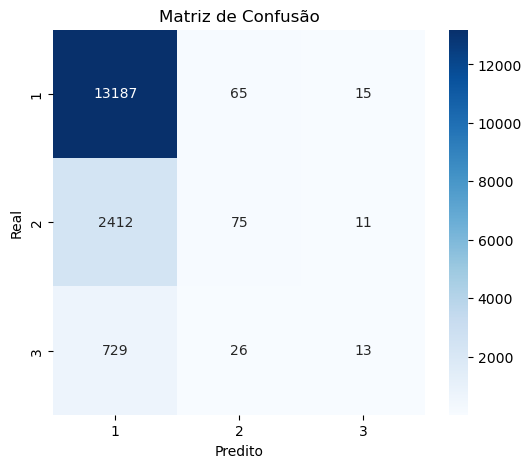

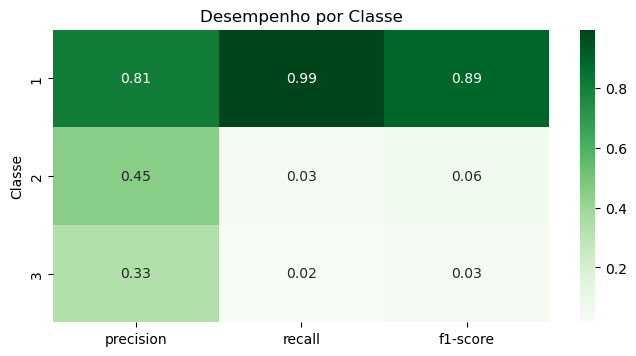


📌 Running Experiment 9/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': 10, 'class_weight': None}

🔧 Config DT: balance=None, normalize=zscore, class_weight=None, max_depth=10


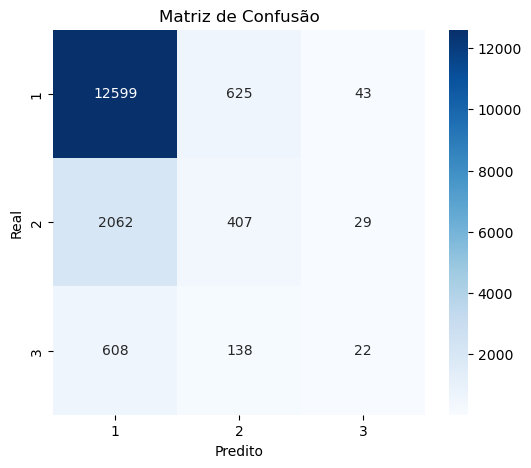

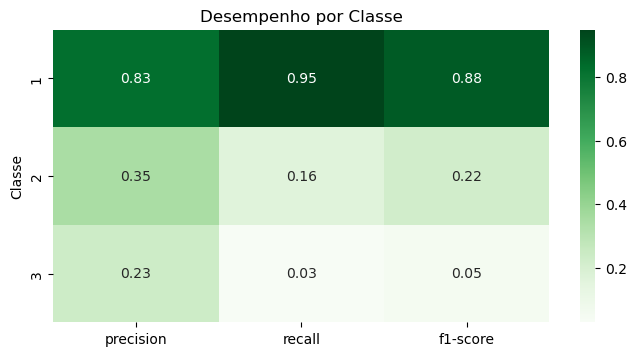


📌 Running Experiment 10/10
{'normalize': 'zscore', 'balance_strategy': None, 'max_depth': 20, 'class_weight': None}

🔧 Config DT: balance=None, normalize=zscore, class_weight=None, max_depth=20


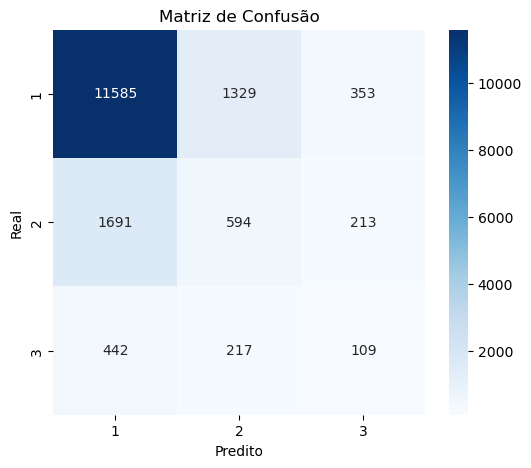

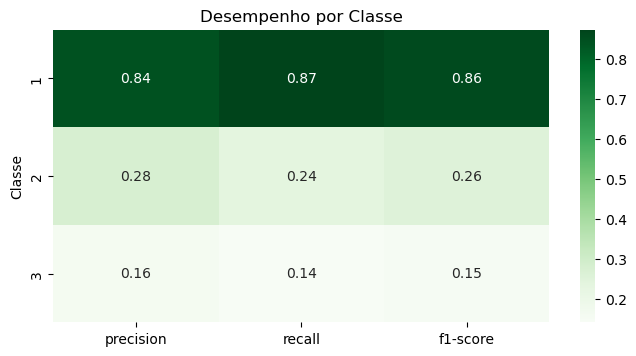

In [47]:
results_decision_tree_word2vec = []

for i, config in enumerate(dt_experiment_configs):
    print(f"\n📌 Running Experiment {i+1}/{len(dt_experiment_configs)}")
    print(config)

    report_dict = run_decision_tree_experiment(
        X_word2vec_train, X_word2vec_test, y_word2vec_train, y_word2vec_test,
        normalize=config["normalize"],
        balance_strategy=config["balance_strategy"],
        max_depth=config["max_depth"],
        class_weight=config["class_weight"],
        verbose=False
    )

    # Store results
    macro_f1 = report_dict["macro avg"]["f1-score"]
    most_viral_class = str(max(np.unique(y_word2vec_test)))
    viral_f1 = report_dict.get(most_viral_class, {}).get("f1-score", 0.0)
    results_decision_tree_word2vec.append({
        **config,
        "macro_f1": macro_f1,
        "viral_f1": viral_f1
    })

#### Ensemble

In [48]:
from sklearn.ensemble import RandomForestClassifier

def run_random_forest_experiment(
    X_train, X_test, y_train, y_test,
    balance_strategy=None,
    normalize=None,
    class_weight=None,
    n_estimators=100,
    max_depth=None,
    random_state=42,
    verbose=True
):
    print(f"\n🔧 Config RF: balance={balance_strategy}, normalize={normalize}, class_weight={class_weight}, n_estimators={n_estimators}")

    # Normalização
    if normalize == "zscore":
        scaler = StandardScaler()
    elif normalize == "minmax":
        scaler = MinMaxScaler()
    else:
        scaler = None
    if scaler:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # Balanceamento
    if balance_strategy == "smote":
        sampler = SMOTE(random_state=random_state)
    elif balance_strategy == "ros":
        sampler = RandomOverSampler(random_state=random_state)
    elif balance_strategy == "rus":
        sampler = RandomUnderSampler(random_state=random_state)
    else:
        sampler = None
    if sampler:
        X_train, y_train = sampler.fit_resample(X_train, y_train)

    # Treina o modelo
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        class_weight=class_weight,
        random_state=random_state
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    class_labels = sorted(np.unique(y_test))
    target_names = [str(c) for c in class_labels]

    report_dict = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)

    if verbose:
        print("\n📊 Classification Report")
        print(classification_report(y_test, y_pred, target_names=target_names))

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred, labels=class_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.title("Matriz de Confusão")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

    # Curva ROC (somente para binário)
    if len(class_labels) == 2 and hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (área = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel("Falso Positivo (FPR)")
        plt.ylabel("Verdadeiro Positivo (TPR)")
        plt.title("Curva ROC")
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()

    # Heatmap métricas por classe
    metrics_to_plot = ["precision", "recall", "f1-score"]
    df_plot = pd.DataFrame(report_dict).transpose().loc[target_names, metrics_to_plot]
    plt.figure(figsize=(8, len(target_names)*0.6 + 2))
    sns.heatmap(df_plot, annot=True, fmt=".2f", cmap="Greens")
    plt.title("Desempenho por Classe")
    plt.ylabel("Classe")
    plt.show()

    return report_dict

In [49]:
rf_experiment_configs = [
    # Baseline
    {"normalize": None, "balance_strategy": None, "n_estimators": 100, "max_depth": None, "class_weight": None},

    # Variação de normalização
    {"normalize": "zscore", "balance_strategy": None, "n_estimators": 100, "max_depth": None, "class_weight": None},
    {"normalize": "minmax", "balance_strategy": None, "n_estimators": 100, "max_depth": None, "class_weight": None},

    # Class weighting
    {"normalize": "zscore", "balance_strategy": None, "n_estimators": 100, "max_depth": None, "class_weight": "balanced"},

    # Com balanceamento
    {"normalize": "zscore", "balance_strategy": "smote", "n_estimators": 100, "max_depth": None, "class_weight": None},
    {"normalize": "zscore", "balance_strategy": "ros", "n_estimators": 100, "max_depth": None, "class_weight": None},
    {"normalize": "zscore", "balance_strategy": "rus", "n_estimators": 100, "max_depth": None, "class_weight": None},

    # Variações de profundidade
    {"normalize": "zscore", "balance_strategy": None, "n_estimators": 100, "max_depth": 5, "class_weight": None},
    {"normalize": "zscore", "balance_strategy": None, "n_estimators": 100, "max_depth": 10, "class_weight": None},
    {"normalize": "zscore", "balance_strategy": None, "n_estimators": 100, "max_depth": 20, "class_weight": None},

    # Variação no número de estimadores
    {"normalize": "zscore", "balance_strategy": None, "n_estimators": 50, "max_depth": None, "class_weight": None},
    {"normalize": "zscore", "balance_strategy": None, "n_estimators": 200, "max_depth": None, "class_weight": None},
]

##### TF-IDF


📌 Running Experiment 1/12
{'normalize': None, 'balance_strategy': None, 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=None, class_weight=None, n_estimators=100


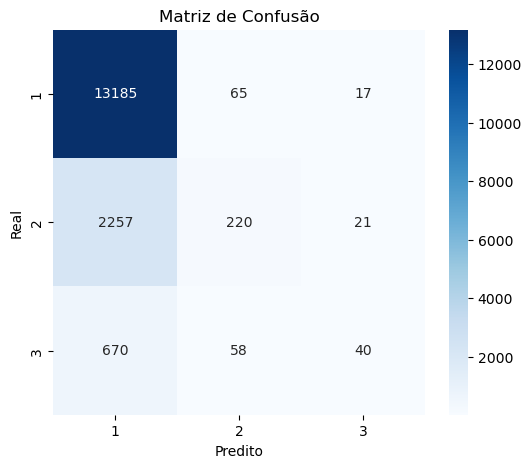

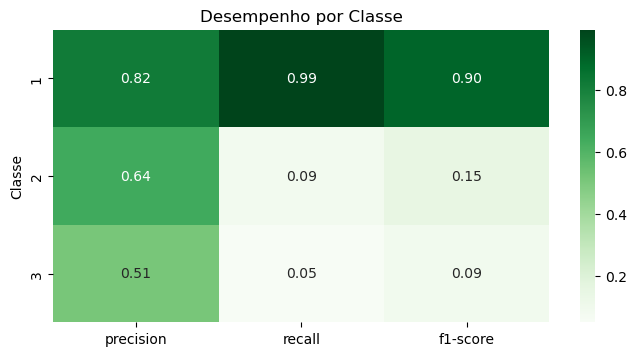


📌 Running Experiment 2/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=100


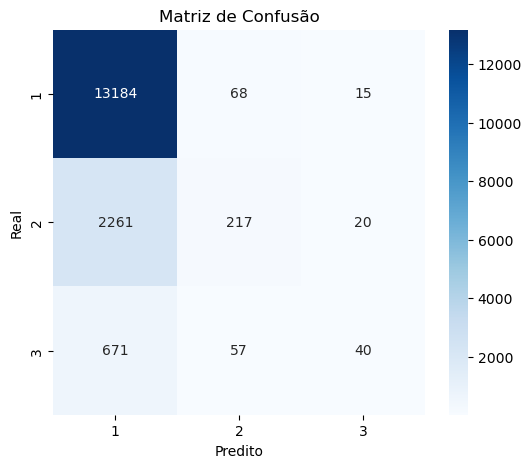

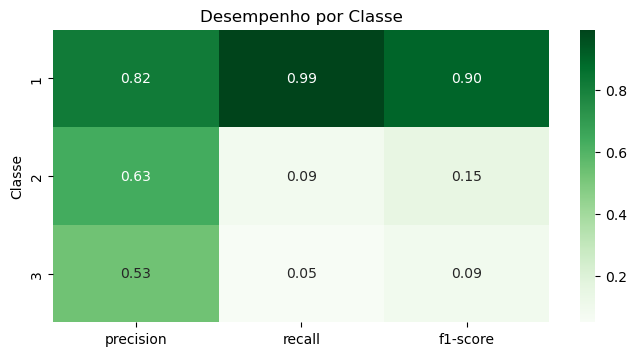


📌 Running Experiment 3/12
{'normalize': 'minmax', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=minmax, class_weight=None, n_estimators=100


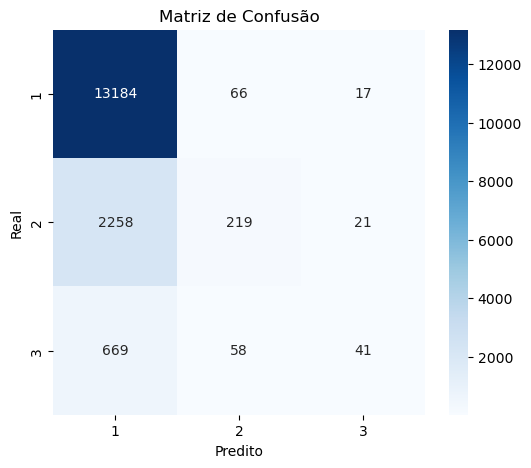

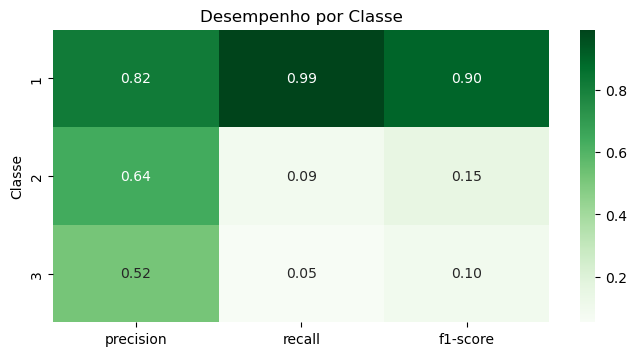


📌 Running Experiment 4/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': None, 'class_weight': 'balanced'}

🔧 Config RF: balance=None, normalize=zscore, class_weight=balanced, n_estimators=100


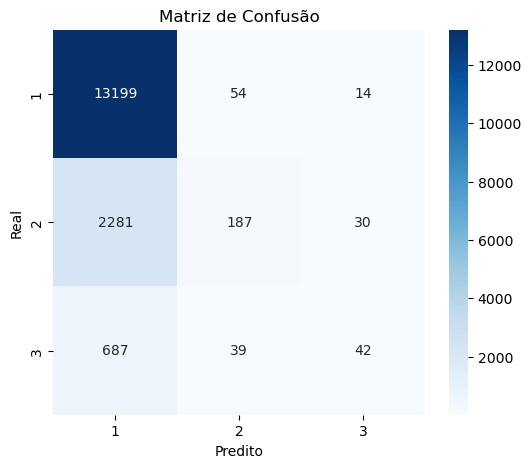

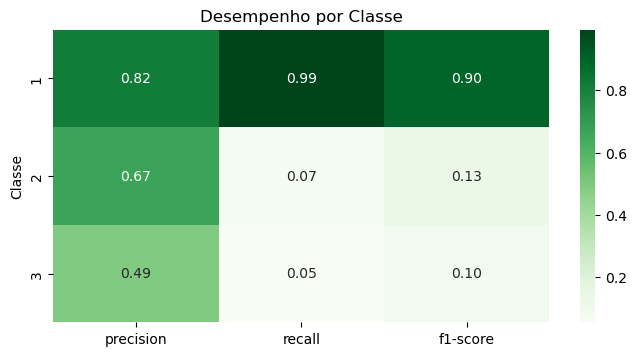


📌 Running Experiment 5/12
{'normalize': 'zscore', 'balance_strategy': 'smote', 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=smote, normalize=zscore, class_weight=None, n_estimators=100


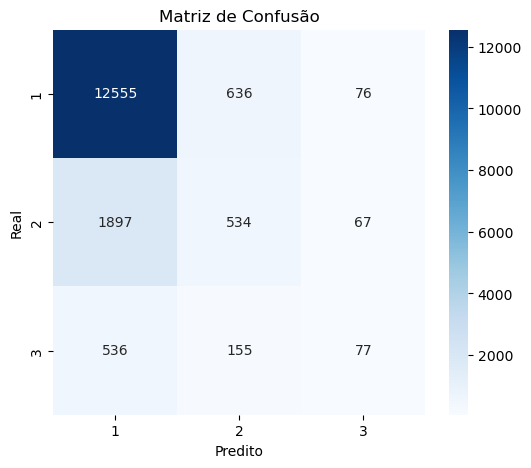

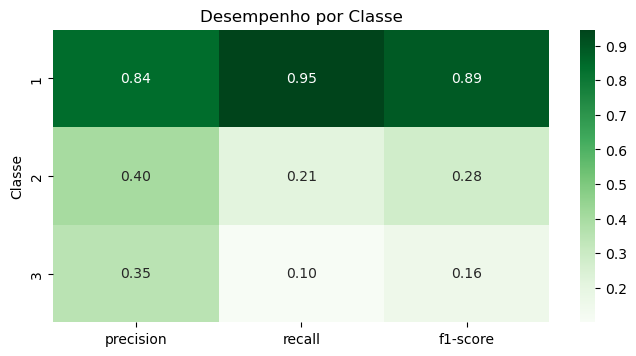


📌 Running Experiment 6/12
{'normalize': 'zscore', 'balance_strategy': 'ros', 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=ros, normalize=zscore, class_weight=None, n_estimators=100


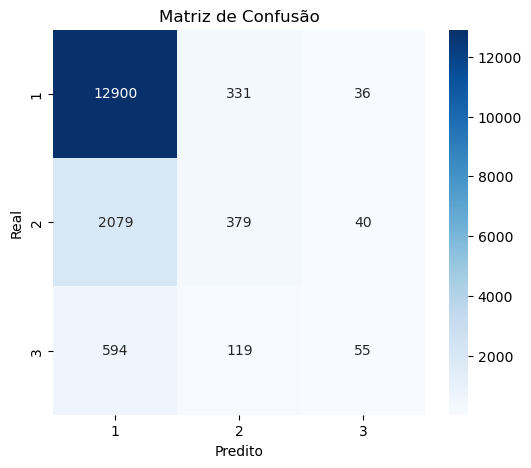

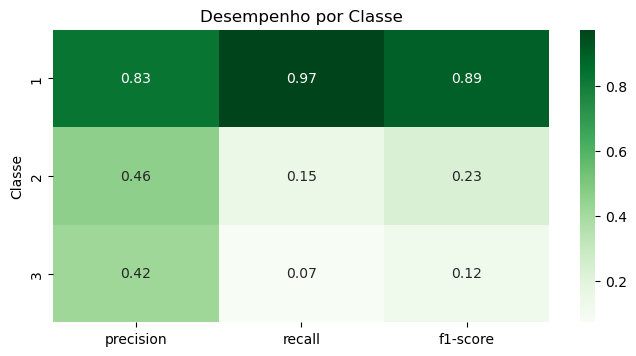


📌 Running Experiment 7/12
{'normalize': 'zscore', 'balance_strategy': 'rus', 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=rus, normalize=zscore, class_weight=None, n_estimators=100


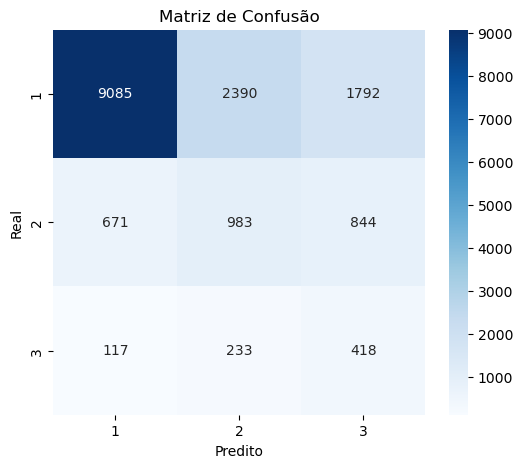

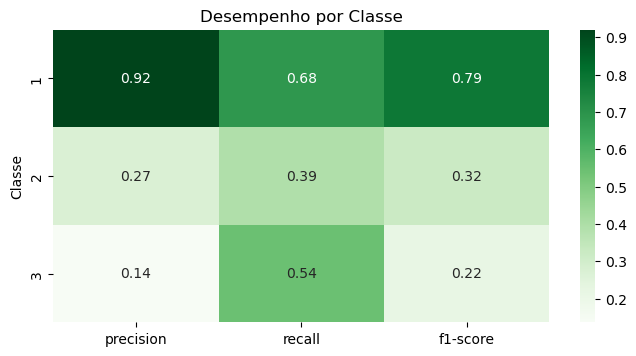


📌 Running Experiment 8/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': 5, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=100


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


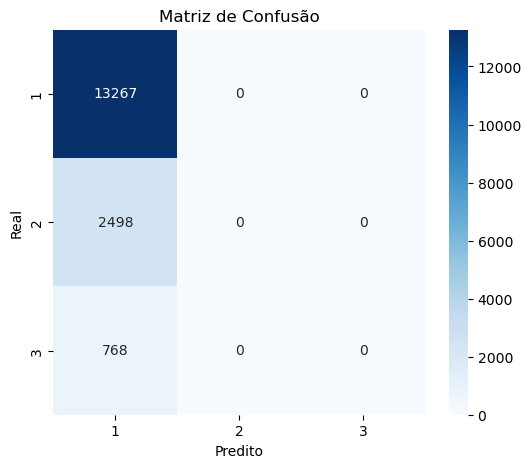

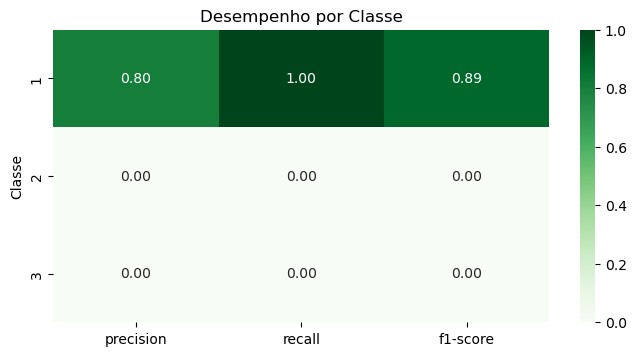


📌 Running Experiment 9/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': 10, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=100


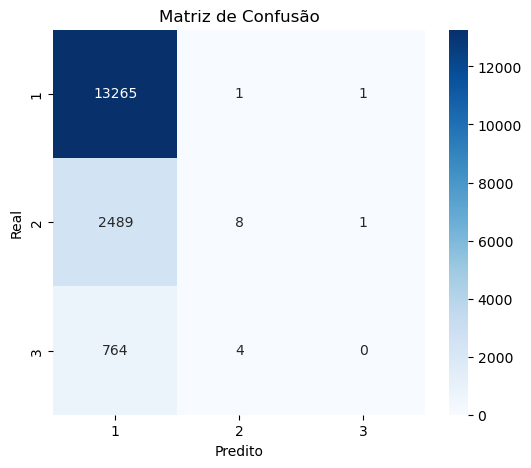

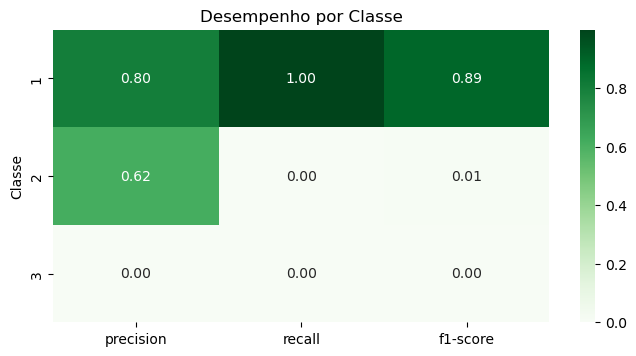


📌 Running Experiment 10/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': 20, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=100


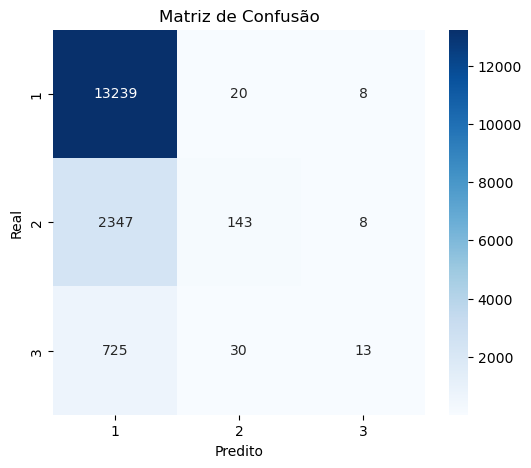

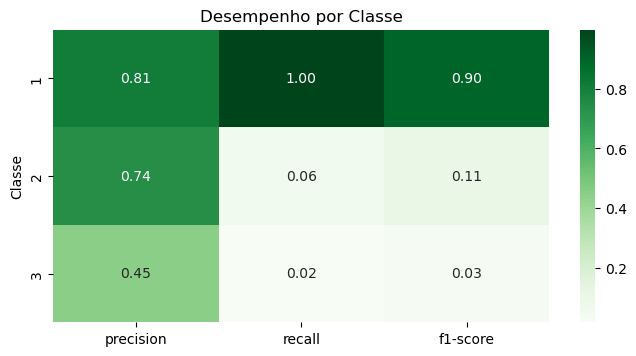


📌 Running Experiment 11/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 50, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=50


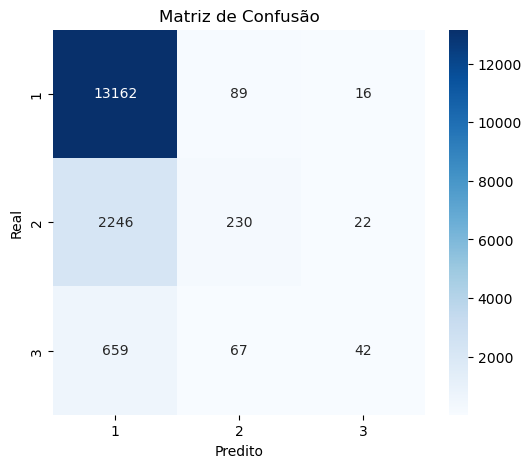

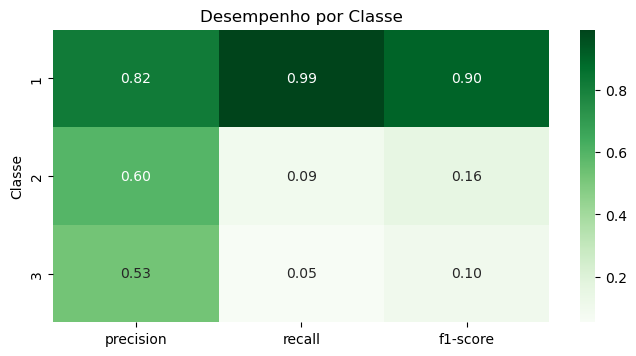


📌 Running Experiment 12/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 200, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=200


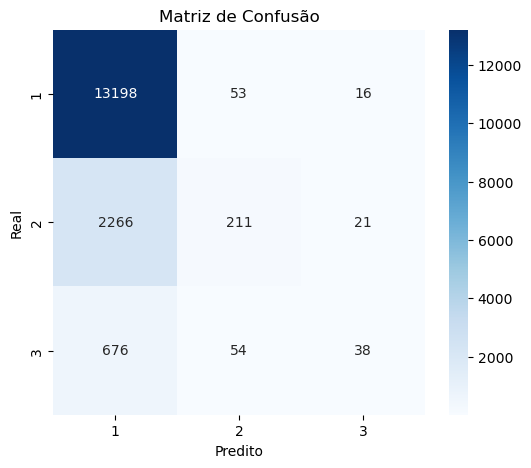

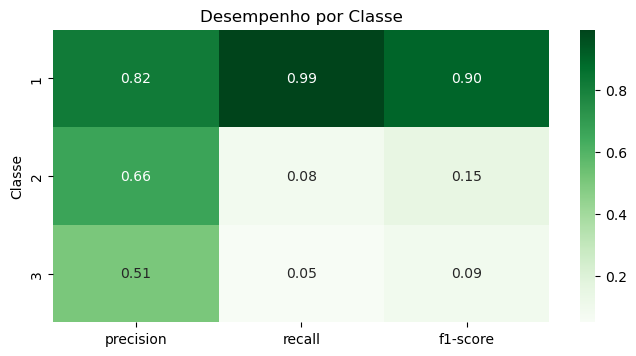

In [50]:
results_ensemble_tfidf = []

for i, config in enumerate(rf_experiment_configs):
    print(f"\n📌 Running Experiment {i+1}/{len(rf_experiment_configs)}")
    print(config)

    report_dict = run_random_forest_experiment(
        X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test,
        normalize=config["normalize"],
        balance_strategy=config["balance_strategy"],
        n_estimators=config["n_estimators"],
        max_depth=config["max_depth"],
        class_weight=config["class_weight"],
        verbose=False
    )

    # Store results
    macro_f1 = report_dict["macro avg"]["f1-score"]
    most_viral_class = str(max(np.unique(y_tfidf_test)))
    viral_f1 = report_dict.get(most_viral_class, {}).get("f1-score", 0.0)
    results_ensemble_tfidf.append({
        **config,
        "macro_f1": macro_f1,
        "viral_f1": viral_f1
    })

##### BOW


📌 Running Experiment 1/12
{'normalize': None, 'balance_strategy': None, 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=None, class_weight=None, n_estimators=100


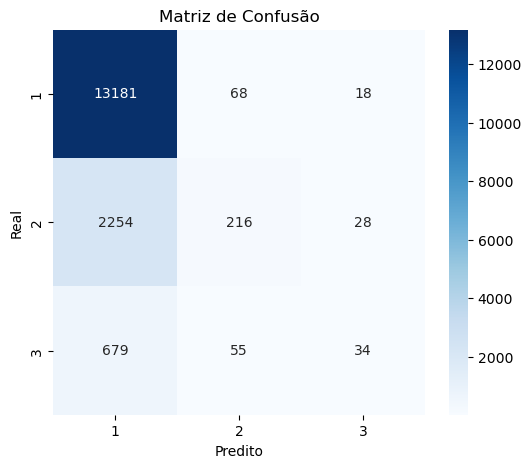

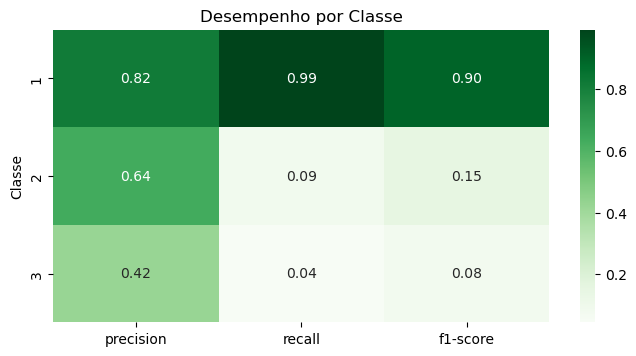


📌 Running Experiment 2/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=100


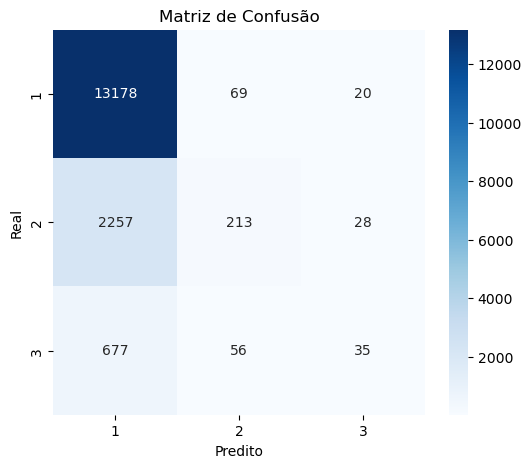

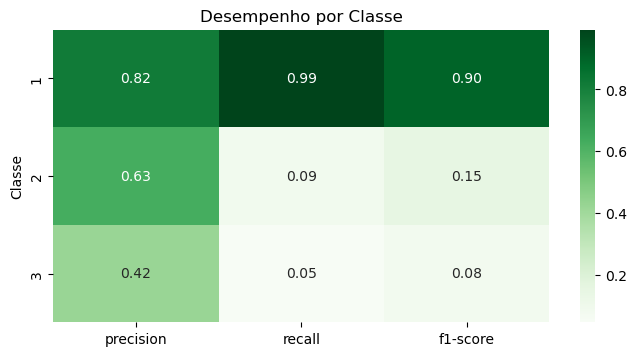


📌 Running Experiment 3/12
{'normalize': 'minmax', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=minmax, class_weight=None, n_estimators=100


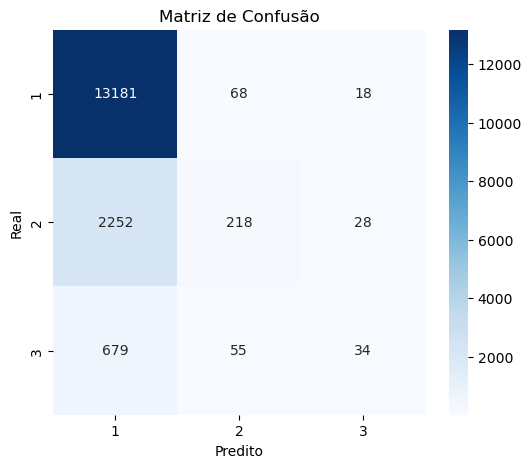

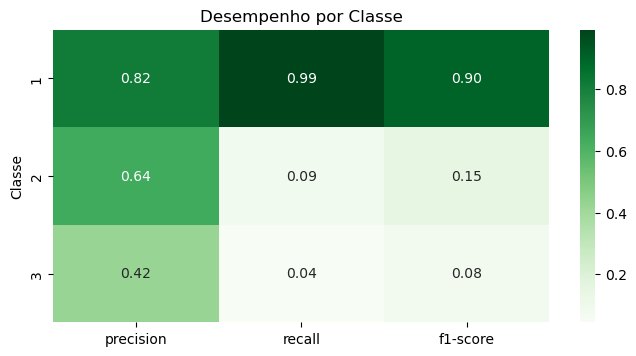


📌 Running Experiment 4/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': None, 'class_weight': 'balanced'}

🔧 Config RF: balance=None, normalize=zscore, class_weight=balanced, n_estimators=100


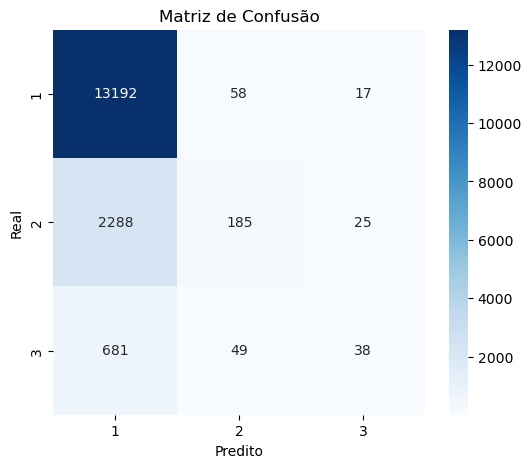

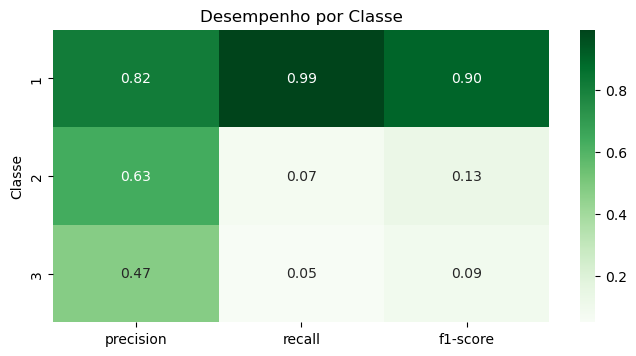


📌 Running Experiment 5/12
{'normalize': 'zscore', 'balance_strategy': 'smote', 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=smote, normalize=zscore, class_weight=None, n_estimators=100


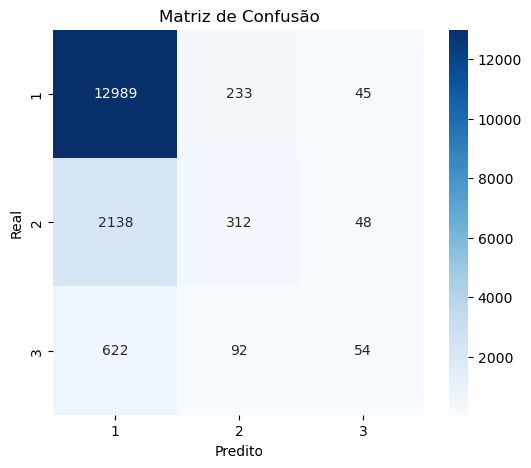

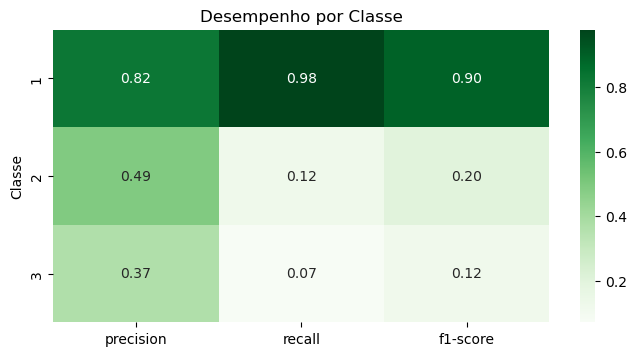


📌 Running Experiment 6/12
{'normalize': 'zscore', 'balance_strategy': 'ros', 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=ros, normalize=zscore, class_weight=None, n_estimators=100


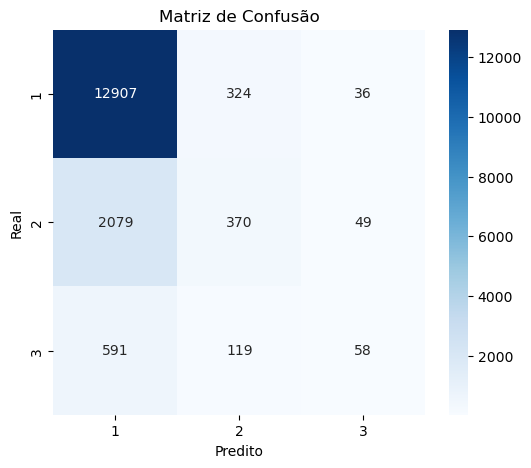

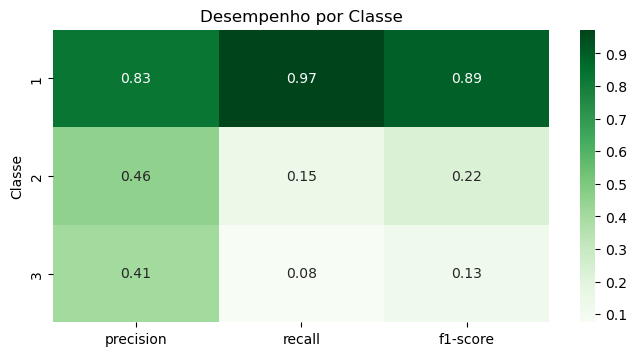


📌 Running Experiment 7/12
{'normalize': 'zscore', 'balance_strategy': 'rus', 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=rus, normalize=zscore, class_weight=None, n_estimators=100


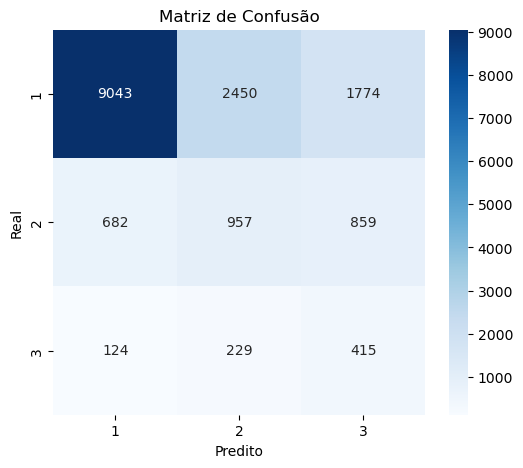

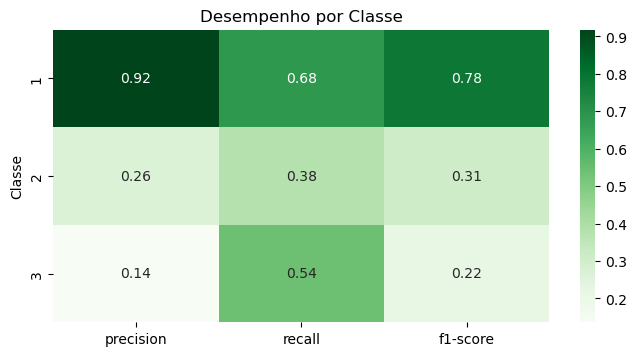


📌 Running Experiment 8/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': 5, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=100


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


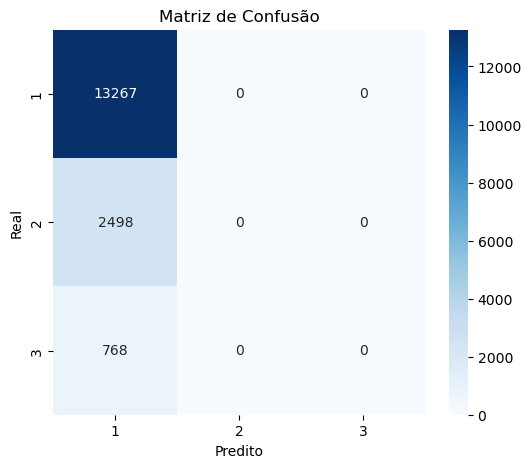

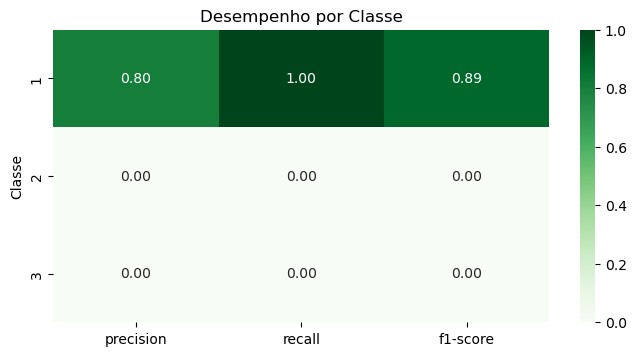


📌 Running Experiment 9/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': 10, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=100


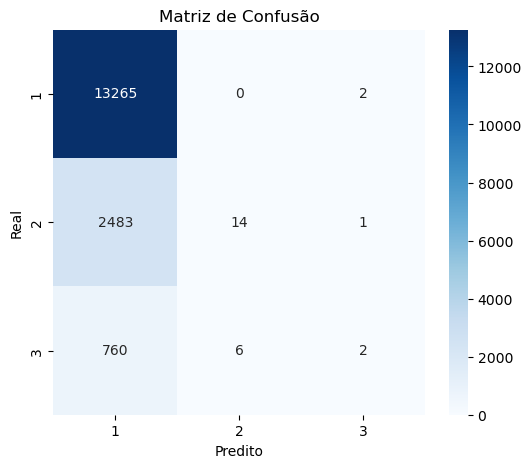

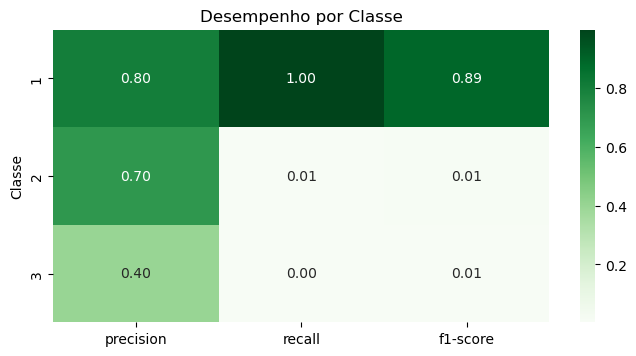


📌 Running Experiment 10/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': 20, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=100


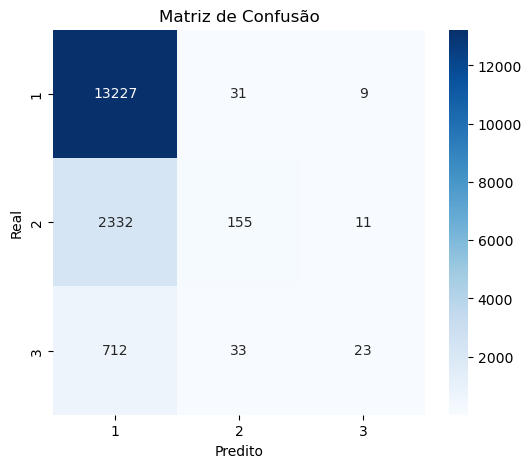

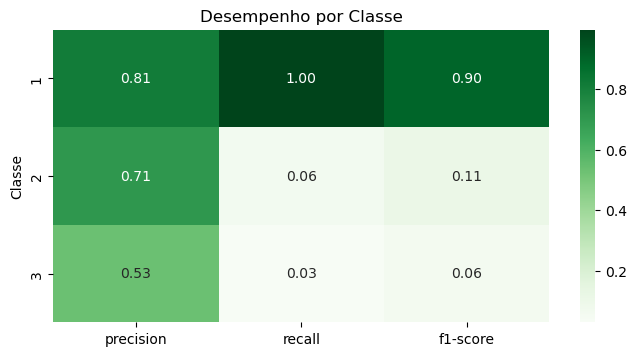


📌 Running Experiment 11/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 50, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=50


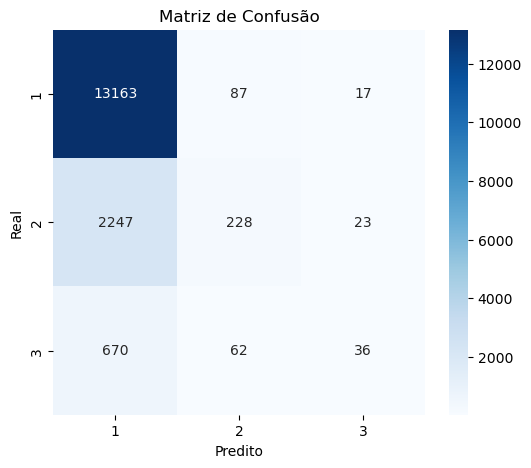

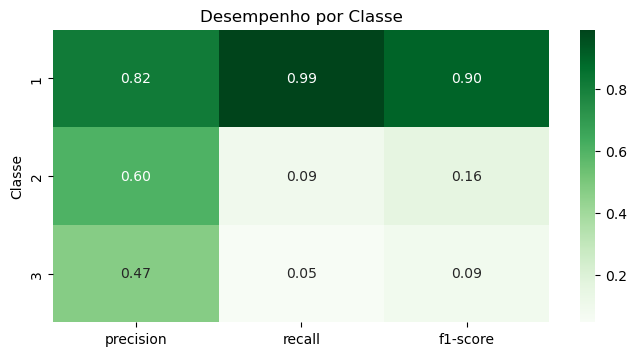


📌 Running Experiment 12/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 200, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=200


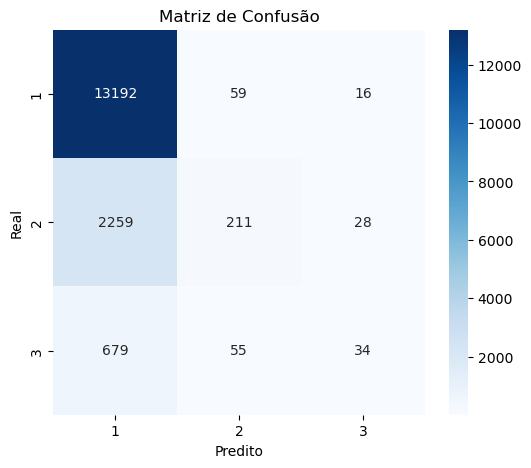

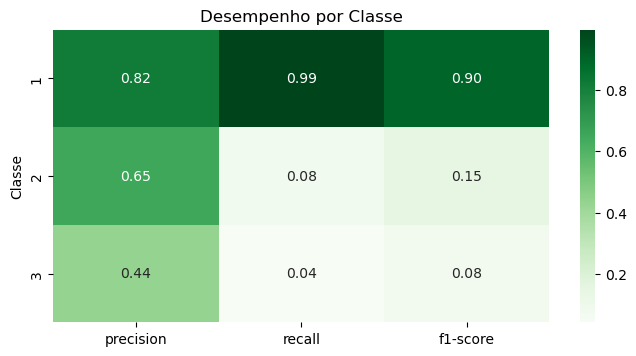

In [51]:
results_ensemble_bow = []

for i, config in enumerate(rf_experiment_configs):
    print(f"\n📌 Running Experiment {i+1}/{len(rf_experiment_configs)}")
    print(config)

    report_dict = run_random_forest_experiment(
        X_bow_train, X_bow_test, y_bow_train, y_bow_test,
        normalize=config["normalize"],
        balance_strategy=config["balance_strategy"],
        n_estimators=config["n_estimators"],
        max_depth=config["max_depth"],
        class_weight=config["class_weight"],
        verbose=False
    )

    # Store results
    macro_f1 = report_dict["macro avg"]["f1-score"]
    most_viral_class = str(max(np.unique(y_bow_test)))
    viral_f1 = report_dict.get(most_viral_class, {}).get("f1-score", 0.0)
    results_ensemble_bow.append({
        **config,
        "macro_f1": macro_f1,
        "viral_f1": viral_f1
    })

##### Word2Vec


📌 Running Experiment 1/12
{'normalize': None, 'balance_strategy': None, 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=None, class_weight=None, n_estimators=100


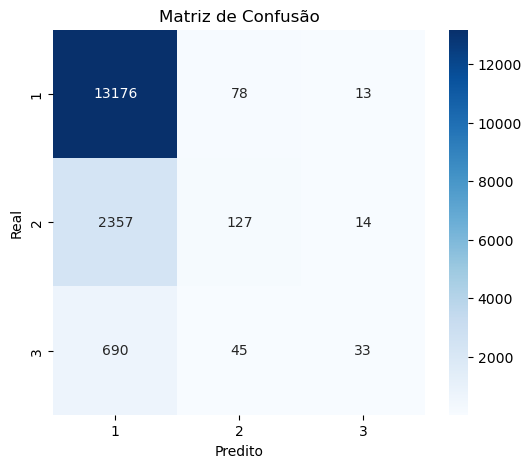

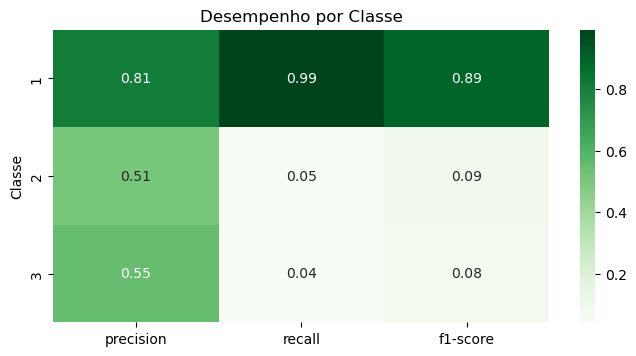


📌 Running Experiment 2/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=100


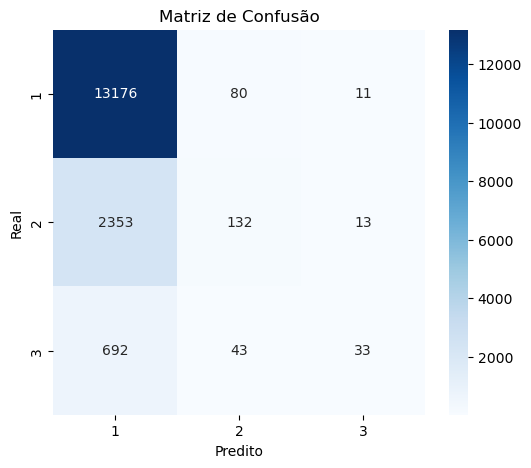

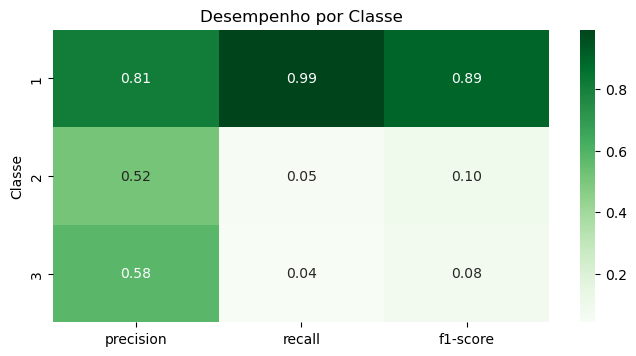


📌 Running Experiment 3/12
{'normalize': 'minmax', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=minmax, class_weight=None, n_estimators=100


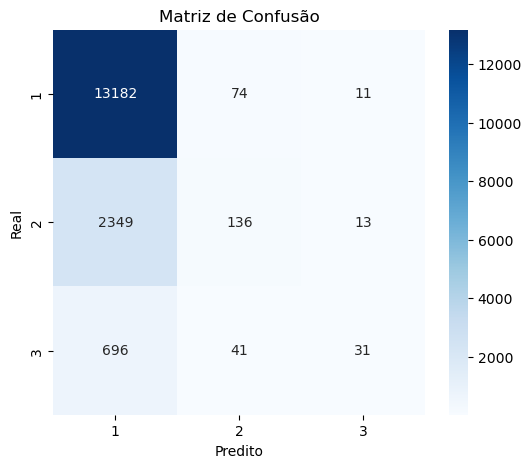

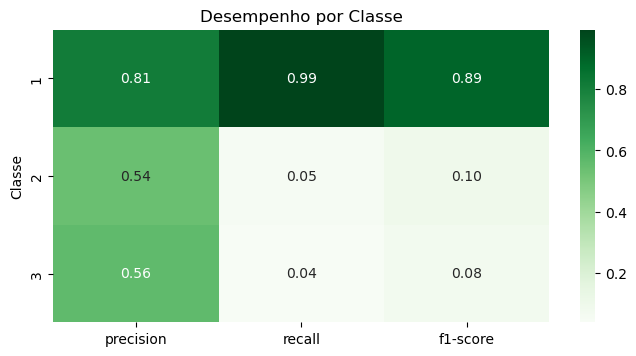


📌 Running Experiment 4/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': None, 'class_weight': 'balanced'}

🔧 Config RF: balance=None, normalize=zscore, class_weight=balanced, n_estimators=100


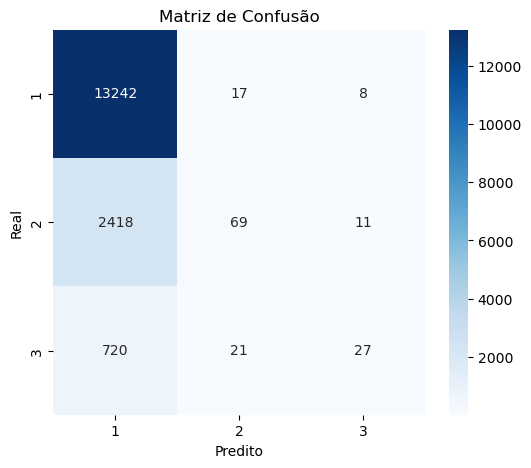

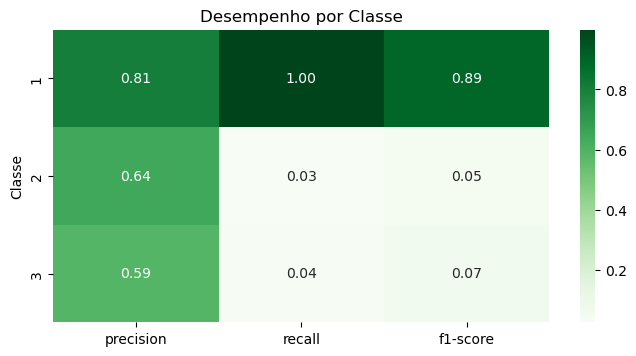


📌 Running Experiment 5/12
{'normalize': 'zscore', 'balance_strategy': 'smote', 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=smote, normalize=zscore, class_weight=None, n_estimators=100


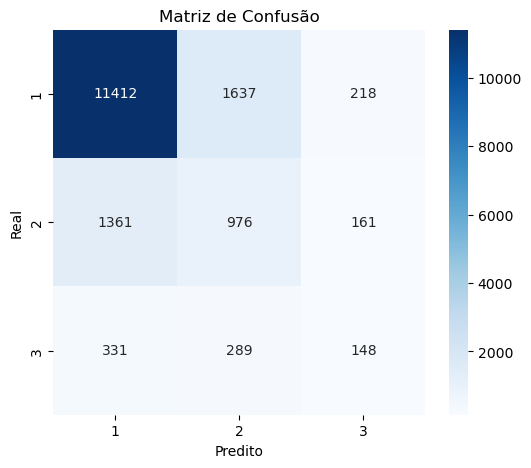

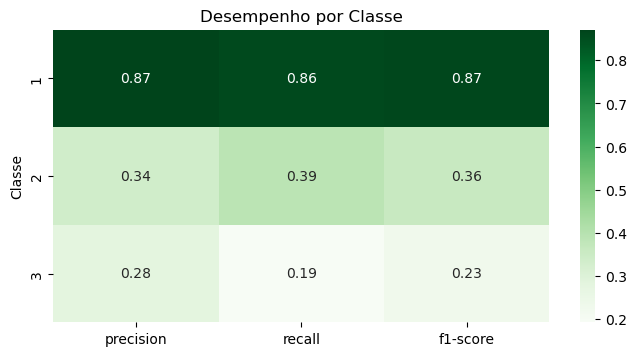


📌 Running Experiment 6/12
{'normalize': 'zscore', 'balance_strategy': 'ros', 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=ros, normalize=zscore, class_weight=None, n_estimators=100


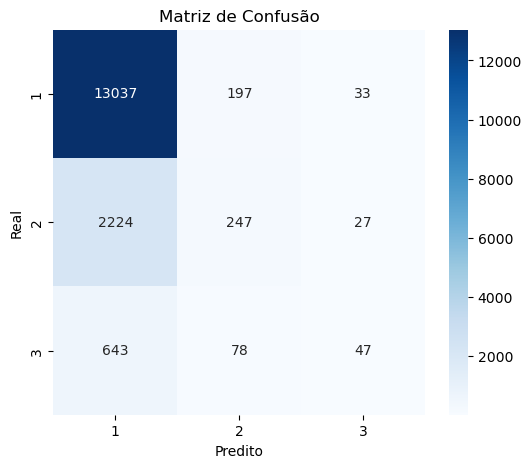

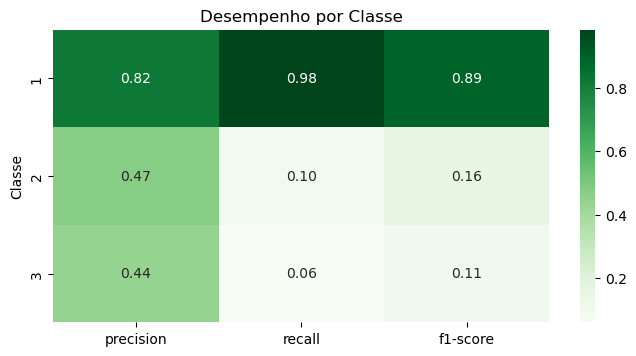


📌 Running Experiment 7/12
{'normalize': 'zscore', 'balance_strategy': 'rus', 'n_estimators': 100, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=rus, normalize=zscore, class_weight=None, n_estimators=100


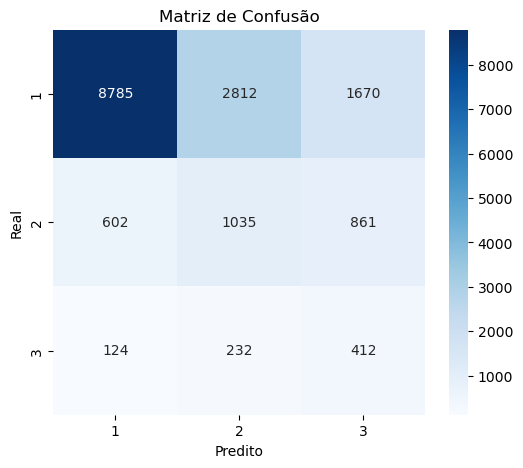

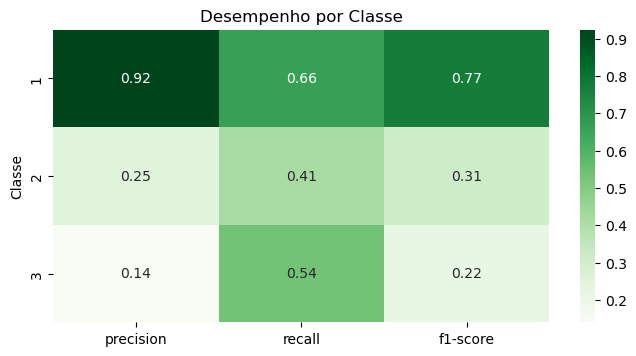


📌 Running Experiment 8/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': 5, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=100


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


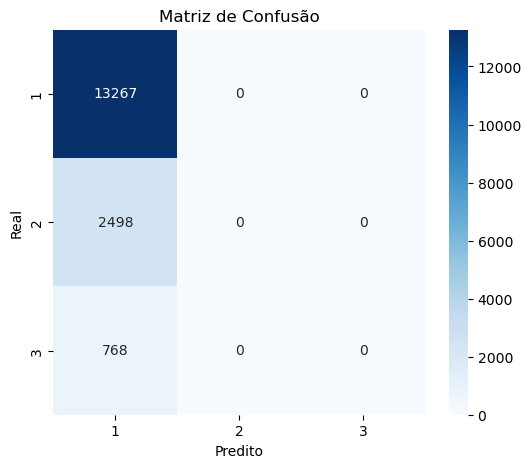

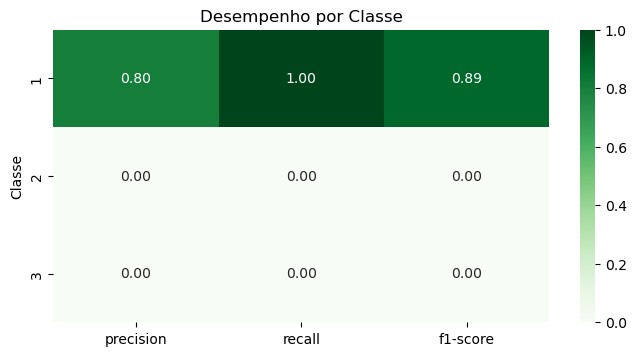


📌 Running Experiment 9/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': 10, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=100


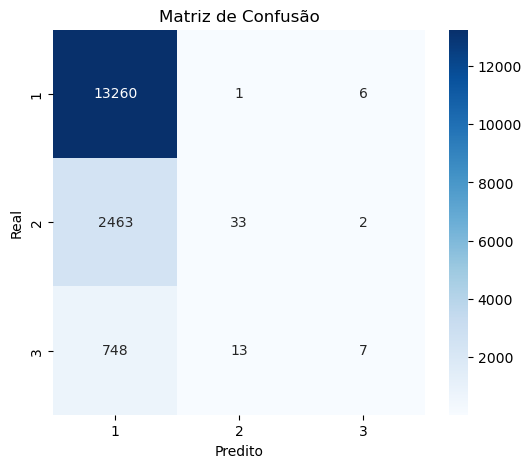

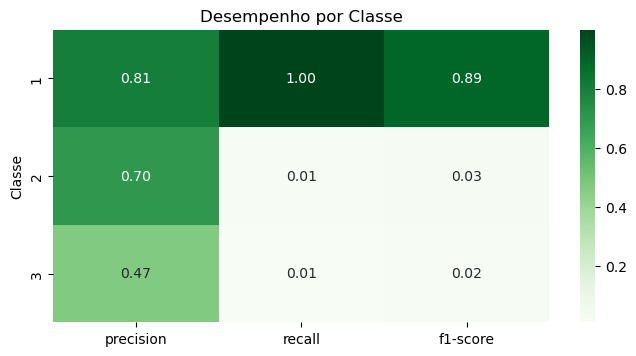


📌 Running Experiment 10/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 100, 'max_depth': 20, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=100


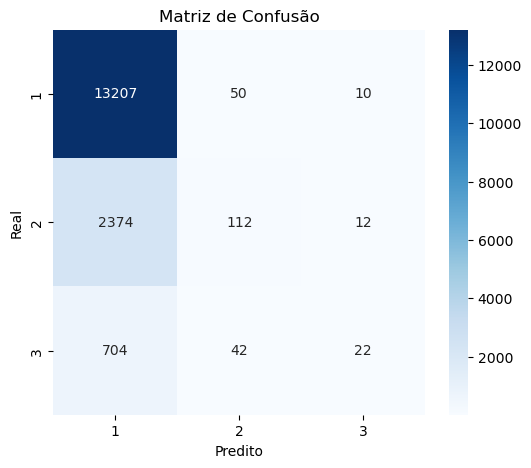

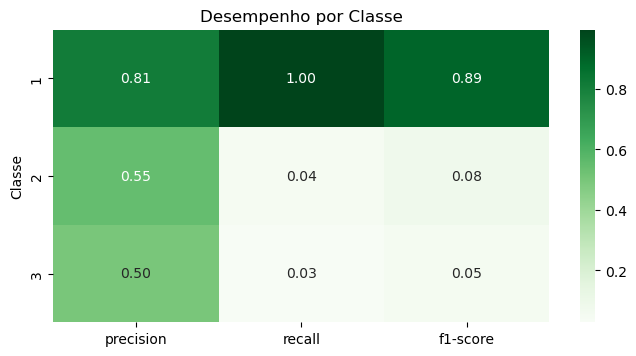


📌 Running Experiment 11/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 50, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=50


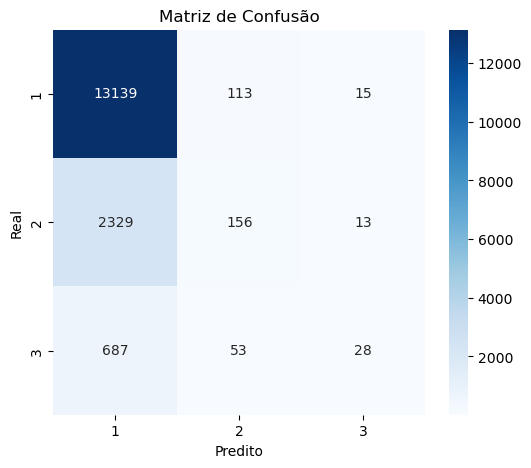

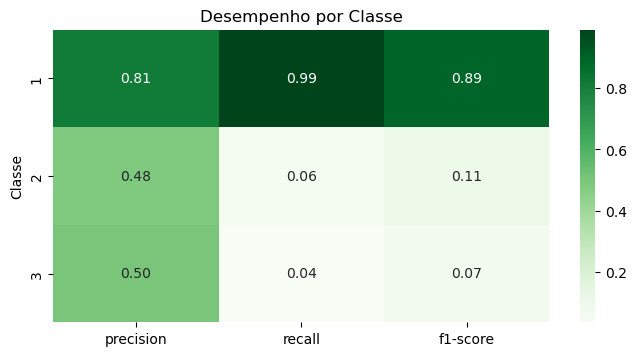


📌 Running Experiment 12/12
{'normalize': 'zscore', 'balance_strategy': None, 'n_estimators': 200, 'max_depth': None, 'class_weight': None}

🔧 Config RF: balance=None, normalize=zscore, class_weight=None, n_estimators=200


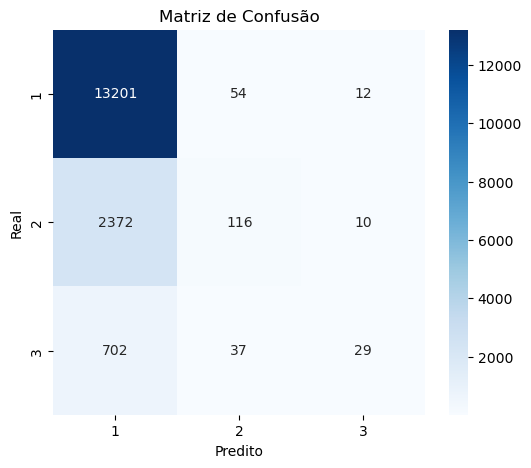

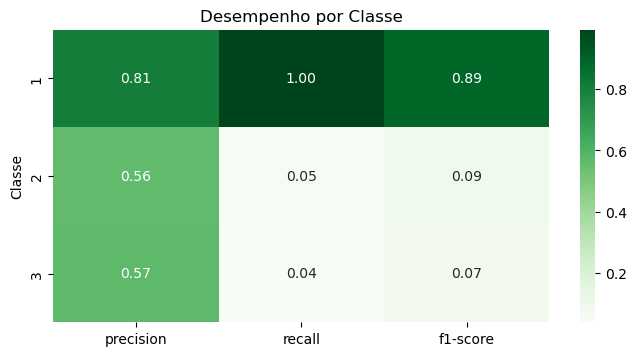

In [52]:
results_ensemble_word2vec = []

for i, config in enumerate(rf_experiment_configs):
    print(f"\n📌 Running Experiment {i+1}/{len(rf_experiment_configs)}")
    print(config)

    report_dict = run_random_forest_experiment(
        X_word2vec_train, X_word2vec_test, y_word2vec_train, y_word2vec_test,
        normalize=config["normalize"],
        balance_strategy=config["balance_strategy"],
        n_estimators=config["n_estimators"],
        max_depth=config["max_depth"],
        class_weight=config["class_weight"],
        verbose=False
    )

    # Store results
    macro_f1 = report_dict["macro avg"]["f1-score"]
    most_viral_class = str(max(np.unique(y_word2vec_test)))
    viral_f1 = report_dict.get(most_viral_class, {}).get("f1-score", 0.0)
    results_ensemble_word2vec.append({
        **config,
        "macro_f1": macro_f1,
        "viral_f1": viral_f1
    })